# Out-of-sample forecasting experiments

We conduct out-of-sample forecasting experiments to understand what kind of text data (topics, sentiment, or uncertainty) helps improve forecasts of three quarterly variables (GDP, Investment, and Consumption) more.

In this notebook, we evaluate the performance of dynamic factor models (DFM) using hard data and survey information. We forecast Consumption growth and establish a benchmark model without the use of text data.

## Experiment Details

- **Data Sources:** Hard data and surveys.
- **Forecast Target:** Consumption growth.
- **Model:** Dynamic Factor Models (DFM).
- **Parameters Explored:**
  - **Number of Global Factors:** 1 to 3
  - **Factor Order:** 1 to 3 (for each number of factors)

In [1]:
import os
import time
import datetime
import pandas as pd
import DFM_function

# Define inputs common to all models
q_var = 'Consumption'              # quarterly variable being forecasted
additional_factors = None          # or "all" or e.g. ['Labor market']
start = '1991-04'

# Generate list of forecast_month strings for quarters from 2008Q1 to 2018Q4
# forecast_month is set to the month corresponding to quarter-end:
# Q1: 'YYYY-03', Q2: 'YYYY-06', Q3: 'YYYY-09', Q4: 'YYYY-12'
forecast_months = []
for year in range(2008, 2019):
    forecast_months.extend([f"{year}-03", f"{year}-06", f"{year}-09", f"{year}-12"])
    
# Define the vintage column names 
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Create directories to save forecasts and MSE results
os.makedirs(f"../forecasts/DFM_hard_surveys_global_factors_{q_var}", exist_ok=True)
os.makedirs(f"../MSE/DFM_hard_surveys_global_factors_{q_var}", exist_ok=True)

# Load the actual growth data
actual_growth_file = f"../{q_var}_growth_actual.csv"
actual_growth = pd.read_csv(actual_growth_file)

# Record overall start time
overall_start = time.time()

# Loop over the number of factors and factor order values from 1 to 3
for num_factors in range(1, 4):  # Varying number of Global factors: 1, 2, 3
    for order in range(1, 4):    # Varying factor order: 1, 2, 3
        
        # Define model-specific parameters
        factor_multiplicities = {'Global': num_factors}
        factor_orders = {'Global': order}

        # Prepare lists to store each quarter's forecasts and row labels
        forecasts_all_quarters = []
        row_labels = []
        
        # Start timing for this model
        start_time = time.time()

        # Loop over each forecast month, get the forecasts, and store the results
        for fm in forecast_months:
            # Use the forecast_month string as the row label
            row_labels.append(fm)

            # Run the forecast function for this quarter
            forecasts_dict = DFM_function.get_forecasts(
                forecast_month = fm,
                q_var = q_var,
                additional_factors = additional_factors,
                factor_multiplicities = factor_multiplicities,
                factor_orders = factor_orders,
                start = start
            )

            # Obtain the correct ordering of vintages
            vintages_order = DFM_function.vintage_dates(fm)
            # Extract the forecast value for each vintage in that order
            quarter_forecasts = [forecasts_dict[vint] for vint in vintages_order]
            forecasts_all_quarters.append(quarter_forecasts)

        # Create a DataFrame with rows labeled by the forecast_month strings and columns as vintage names
        results = pd.DataFrame(forecasts_all_quarters, index=row_labels, columns=vintage_col_names)
        
        # Stop timing for this model and print elapsed time
        elapsed = time.time() - start_time
        elapsed_time = datetime.timedelta(seconds=elapsed)
        print(f"Model with Global factors = {num_factors} and order = {order} estimated in {elapsed_time}.")

        # Construct the output file name
        factors_str = "_".join([
            f"{factor.replace(' ', '_')}_{factor_multiplicities[factor]}_{factor_orders[factor]}"
            for factor in factor_multiplicities])
        file_name = f"forecasts_{q_var}_{factors_str}.csv"

        # Save the CSV file in a subfolder 
        output_path = os.path.join(f"../forecasts/DFM_hard_surveys_global_factors_{q_var}", file_name)
        results.to_csv(output_path, index=True)
        
        # ----- MSE Calculation -----
        # Load forecasts
        forecasts = pd.read_csv(output_path, index_col=0)
        # Make sure the index is a column named "date"
        forecasts.index.name = "date"
        forecasts.reset_index(inplace=True)

        # Merge dfs by date 
        merged = pd.merge(forecasts, actual_growth, on="date", how="inner")

        # Calculate the Mean Squared Error (MSE) for each vintage column
        mse_dict = {}
        for col in vintage_col_names:
            mse = ((merged[col] - merged["growth"]) ** 2).mean()
            mse_dict[col] = mse

        # Create a df with one row (the MSE values for each forecasting horizon)
        mse_df = pd.DataFrame(mse_dict, index=[0])

        # Save MSE results to CSV
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_output_path = os.path.join(f"../MSE/DFM_hard_surveys_global_factors_{q_var}", mse_file_name)
        mse_df.to_csv(mse_output_path, index=False)
        
# Stop overall timing and print overall elapsed time
overall_elapsed = time.time() - overall_start
overall_elapsed_time = datetime.timedelta(seconds=overall_elapsed)
print(f"Overall time taken for running all models: {overall_elapsed_time}.")

EM start iterations, llf=-9188.4
EM iteration 50, llf=-8980.2, convergence criterion=1.6988e-06
EM converged at iteration 65, llf=-8980.1, convergence criterion=9.8775e-07 < tolerance=1e-06
EM start iterations, llf=-9201.2
EM iteration 50, llf=-8992.5, convergence criterion=1.6968e-06
EM converged at iteration 65, llf=-8992.4, convergence criterion=9.8653e-07 < tolerance=1e-06
EM start iterations, llf=-9240.7
EM iteration 50, llf=-9029.5, convergence criterion=1.6943e-06
EM converged at iteration 65, llf=-9029.3, convergence criterion=9.8479e-07 < tolerance=1e-06
EM start iterations, llf=-9247.5
EM iteration 50, llf=-9036.5, convergence criterion=1.6939e-06
EM converged at iteration 65, llf=-9036.4, convergence criterion=9.8451e-07 < tolerance=1e-06
EM start iterations, llf=-9297
EM iteration 50, llf=-9080.9, convergence criterion=1.7223e-06
EM converged at iteration 66, llf=-9080.8, convergence criterion=9.7228e-07 < tolerance=1e-06
EM start iterations, llf=-9305.4
EM iteration 50, ll

EM converged at iteration 59, llf=-9864.6, convergence criterion=9.6561e-07 < tolerance=1e-06
EM start iterations, llf=-10073
EM iteration 50, llf=-9899, convergence criterion=1.3511e-06
EM converged at iteration 58, llf=-9899, convergence criterion=9.9236e-07 < tolerance=1e-06
EM start iterations, llf=-10081
EM iteration 50, llf=-9906.1, convergence criterion=1.3505e-06
EM converged at iteration 58, llf=-9906, convergence criterion=9.9201e-07 < tolerance=1e-06
EM start iterations, llf=-10110
EM iteration 50, llf=-9930.8, convergence criterion=1.194e-06
EM converged at iteration 55, llf=-9930.7, convergence criterion=9.7511e-07 < tolerance=1e-06
EM start iterations, llf=-10121
EM iteration 50, llf=-9940.8, convergence criterion=1.1916e-06
EM converged at iteration 55, llf=-9940.8, convergence criterion=9.7312e-07 < tolerance=1e-06
EM start iterations, llf=-10168
EM iteration 50, llf=-9994.5, convergence criterion=1.1649e-06
EM converged at iteration 54, llf=-9994.5, convergence criteri

EM converged at iteration 52, llf=-10844, convergence criterion=9.7546e-07 < tolerance=1e-06
EM start iterations, llf=-11034
EM iteration 50, llf=-10862, convergence criterion=1.0808e-06
EM converged at iteration 52, llf=-10862, convergence criterion=9.9446e-07 < tolerance=1e-06
EM start iterations, llf=-11039
EM iteration 50, llf=-10874, convergence criterion=1.0809e-06
EM converged at iteration 52, llf=-10874, convergence criterion=9.9456e-07 < tolerance=1e-06
EM start iterations, llf=-11076
EM iteration 50, llf=-10919, convergence criterion=1.0729e-06
EM converged at iteration 52, llf=-10918, convergence criterion=9.8751e-07 < tolerance=1e-06
EM start iterations, llf=-11076
EM iteration 50, llf=-10919, convergence criterion=1.0729e-06
EM converged at iteration 52, llf=-10918, convergence criterion=9.8751e-07 < tolerance=1e-06
EM start iterations, llf=-11087
EM iteration 50, llf=-10930, convergence criterion=1.0712e-06
EM converged at iteration 52, llf=-10930, convergence criterion=9

EM converged at iteration 54, llf=-11744, convergence criterion=9.8428e-07 < tolerance=1e-06
EM start iterations, llf=-11942
EM iteration 50, llf=-11775, convergence criterion=1.1455e-06
EM converged at iteration 54, llf=-11775, convergence criterion=9.8045e-07 < tolerance=1e-06
EM start iterations, llf=-11942
EM iteration 50, llf=-11775, convergence criterion=1.1455e-06
EM converged at iteration 54, llf=-11775, convergence criterion=9.8045e-07 < tolerance=1e-06
EM start iterations, llf=-11951
EM iteration 50, llf=-11784, convergence criterion=1.1444e-06
EM converged at iteration 54, llf=-11784, convergence criterion=9.7952e-07 < tolerance=1e-06
EM start iterations, llf=-11991
EM iteration 50, llf=-11825, convergence criterion=1.1398e-06
EM converged at iteration 54, llf=-11825, convergence criterion=9.7569e-07 < tolerance=1e-06
EM start iterations, llf=-12002
EM iteration 50, llf=-11836, convergence criterion=1.1362e-06
EM converged at iteration 54, llf=-11836, convergence criterion=9

EM converged at iteration 53, llf=-12628, convergence criterion=9.7735e-07 < tolerance=1e-06
EM start iterations, llf=-12821
EM iteration 50, llf=-12636, convergence criterion=1.102e-06
EM converged at iteration 53, llf=-12636, convergence criterion=9.7841e-07 < tolerance=1e-06
EM start iterations, llf=-12861
EM iteration 50, llf=-12676, convergence criterion=1.0967e-06
EM converged at iteration 53, llf=-12676, convergence criterion=9.7383e-07 < tolerance=1e-06
EM start iterations, llf=-12870
EM iteration 50, llf=-12685, convergence criterion=1.0945e-06
EM converged at iteration 53, llf=-12685, convergence criterion=9.7193e-07 < tolerance=1e-06
EM start iterations, llf=-12907
EM iteration 50, llf=-12722, convergence criterion=1.0888e-06
EM converged at iteration 53, llf=-12722, convergence criterion=9.6706e-07 < tolerance=1e-06
EM start iterations, llf=-12915
EM iteration 50, llf=-12729, convergence criterion=1.089e-06
EM converged at iteration 53, llf=-12729, convergence criterion=9.6

EM converged at iteration 64, llf=-13534, convergence criterion=9.8723e-07 < tolerance=1e-06
EM start iterations, llf=-13731
EM iteration 50, llf=-13539, convergence criterion=1.5804e-06
EM converged at iteration 64, llf=-13539, convergence criterion=9.8681e-07 < tolerance=1e-06
EM start iterations, llf=-13772
EM iteration 50, llf=-13580, convergence criterion=1.5908e-06
EM converged at iteration 64, llf=-13579, convergence criterion=9.9338e-07 < tolerance=1e-06
EM start iterations, llf=-13780
EM iteration 50, llf=-13586, convergence criterion=1.5898e-06
EM converged at iteration 64, llf=-13586, convergence criterion=9.9267e-07 < tolerance=1e-06
EM start iterations, llf=-13815
EM iteration 50, llf=-13621, convergence criterion=1.5857e-06
EM converged at iteration 64, llf=-13621, convergence criterion=9.902e-07 < tolerance=1e-06
EM start iterations, llf=-13815
EM iteration 50, llf=-13621, convergence criterion=1.5857e-06
EM converged at iteration 64, llf=-13621, convergence criterion=9.

EM converged at iteration 65, llf=-14222, convergence criterion=9.8056e-07 < tolerance=1e-06
EM start iterations, llf=-14437
EM iteration 50, llf=-14230, convergence criterion=1.6164e-06
EM converged at iteration 65, llf=-14229, convergence criterion=9.806e-07 < tolerance=1e-06
EM start iterations, llf=-14483
EM iteration 50, llf=-14274, convergence criterion=1.6107e-06
EM converged at iteration 65, llf=-14273, convergence criterion=9.7696e-07 < tolerance=1e-06
EM start iterations, llf=-14483
EM iteration 50, llf=-14274, convergence criterion=1.6107e-06
EM converged at iteration 65, llf=-14273, convergence criterion=9.7696e-07 < tolerance=1e-06
EM start iterations, llf=-14488
EM iteration 50, llf=-14279, convergence criterion=1.6104e-06
EM converged at iteration 65, llf=-14279, convergence criterion=9.768e-07 < tolerance=1e-06
EM start iterations, llf=-14528
EM iteration 50, llf=-14317, convergence criterion=1.6072e-06
EM converged at iteration 65, llf=-14317, convergence criterion=9.7

EM converged at iteration 66, llf=-14834, convergence criterion=9.8181e-07 < tolerance=1e-06
Model with Global factors = 1 and order = 1 estimated in 1:40:16.349638.
EM start iterations, llf=-9188.4
EM iteration 50, llf=-8976.4, convergence criterion=2.0858e-06
EM converged at iteration 71, llf=-8976.1, convergence criterion=9.8857e-07 < tolerance=1e-06
EM start iterations, llf=-9201.2
EM iteration 50, llf=-8988.7, convergence criterion=2.0831e-06
EM converged at iteration 71, llf=-8988.4, convergence criterion=9.8725e-07 < tolerance=1e-06
EM start iterations, llf=-9240.7
EM iteration 50, llf=-9026.1, convergence criterion=2.1317e-06
EM converged at iteration 72, llf=-9025.8, convergence criterion=9.8139e-07 < tolerance=1e-06
EM start iterations, llf=-9247.5
EM iteration 50, llf=-9033.1, convergence criterion=2.1329e-06
EM converged at iteration 72, llf=-9032.8, convergence criterion=9.8183e-07 < tolerance=1e-06
EM start iterations, llf=-9297
EM iteration 50, llf=-9077.4, convergence c

EM converged at iteration 63, llf=-9853.7, convergence criterion=9.9405e-07 < tolerance=1e-06
EM start iterations, llf=-10037
EM iteration 50, llf=-9860.2, convergence criterion=1.6294e-06
EM converged at iteration 63, llf=-9860, convergence criterion=9.9072e-07 < tolerance=1e-06
EM start iterations, llf=-10073
EM iteration 50, llf=-9894.5, convergence criterion=1.6038e-06
EM converged at iteration 63, llf=-9894.3, convergence criterion=9.7593e-07 < tolerance=1e-06
EM start iterations, llf=-10080
EM iteration 50, llf=-9901.6, convergence criterion=1.6051e-06
EM converged at iteration 63, llf=-9901.4, convergence criterion=9.7689e-07 < tolerance=1e-06
EM start iterations, llf=-10110
EM iteration 50, llf=-9926.3, convergence criterion=1.4498e-06
EM converged at iteration 60, llf=-9926.2, convergence criterion=9.7201e-07 < tolerance=1e-06
EM start iterations, llf=-10121
EM iteration 50, llf=-9936.3, convergence criterion=1.4416e-06
EM converged at iteration 60, llf=-9936.2, convergence cr

EM converged at iteration 62, llf=-10840, convergence criterion=9.6637e-07 < tolerance=1e-06
EM start iterations, llf=-11007
EM iteration 50, llf=-10841, convergence criterion=1.4574e-06
EM converged at iteration 60, llf=-10841, convergence criterion=9.806e-07 < tolerance=1e-06
EM start iterations, llf=-11033
EM iteration 50, llf=-10859, convergence criterion=1.4336e-06
EM converged at iteration 59, llf=-10859, convergence criterion=9.9663e-07 < tolerance=1e-06
EM start iterations, llf=-11039
EM iteration 50, llf=-10871, convergence criterion=1.4842e-06
EM converged at iteration 60, llf=-10871, convergence criterion=9.964e-07 < tolerance=1e-06
EM start iterations, llf=-11076
EM iteration 50, llf=-10916, convergence criterion=1.5957e-06
EM converged at iteration 63, llf=-10916, convergence criterion=9.7501e-07 < tolerance=1e-06
EM start iterations, llf=-11076
EM iteration 50, llf=-10916, convergence criterion=1.5957e-06
EM converged at iteration 63, llf=-10916, convergence criterion=9.7

EM converged at iteration 65, llf=-11736, convergence criterion=9.8189e-07 < tolerance=1e-06
EM start iterations, llf=-11908
EM iteration 50, llf=-11742, convergence criterion=1.6525e-06
EM converged at iteration 64, llf=-11742, convergence criterion=9.9793e-07 < tolerance=1e-06
EM start iterations, llf=-11941
EM iteration 50, llf=-11773, convergence criterion=1.6055e-06
EM converged at iteration 63, llf=-11773, convergence criterion=9.9691e-07 < tolerance=1e-06
EM start iterations, llf=-11941
EM iteration 50, llf=-11773, convergence criterion=1.6055e-06
EM converged at iteration 63, llf=-11773, convergence criterion=9.9691e-07 < tolerance=1e-06
EM start iterations, llf=-11951
EM iteration 50, llf=-11782, convergence criterion=1.6053e-06
EM converged at iteration 63, llf=-11782, convergence criterion=9.9708e-07 < tolerance=1e-06
EM start iterations, llf=-11991
EM iteration 50, llf=-11823, convergence criterion=1.6037e-06
EM converged at iteration 63, llf=-11822, convergence criterion=9

EM converged at iteration 60, llf=-12625, convergence criterion=9.935e-07 < tolerance=1e-06
EM start iterations, llf=-12811
EM iteration 50, llf=-12625, convergence criterion=1.4554e-06
EM converged at iteration 60, llf=-12625, convergence criterion=9.935e-07 < tolerance=1e-06
EM start iterations, llf=-12820
EM iteration 50, llf=-12634, convergence criterion=1.4536e-06
EM converged at iteration 60, llf=-12633, convergence criterion=9.9118e-07 < tolerance=1e-06
EM start iterations, llf=-12860
EM iteration 50, llf=-12673, convergence criterion=1.4413e-06
EM converged at iteration 60, llf=-12673, convergence criterion=9.8295e-07 < tolerance=1e-06
EM start iterations, llf=-12869
EM iteration 50, llf=-12682, convergence criterion=1.4387e-06
EM converged at iteration 60, llf=-12682, convergence criterion=9.8137e-07 < tolerance=1e-06
EM start iterations, llf=-12907
EM iteration 50, llf=-12719, convergence criterion=1.4348e-06
EM converged at iteration 60, llf=-12719, convergence criterion=9.7

EM converged at iteration 69, llf=-13494, convergence criterion=9.9785e-07 < tolerance=1e-06
EM start iterations, llf=-13725
EM iteration 50, llf=-13531, convergence criterion=1.8687e-06
EM converged at iteration 69, llf=-13531, convergence criterion=9.9693e-07 < tolerance=1e-06
EM start iterations, llf=-13730
EM iteration 50, llf=-13537, convergence criterion=1.8669e-06
EM converged at iteration 69, llf=-13537, convergence criterion=9.9589e-07 < tolerance=1e-06
EM start iterations, llf=-13772
EM iteration 50, llf=-13577, convergence criterion=1.8716e-06
EM converged at iteration 69, llf=-13577, convergence criterion=9.9831e-07 < tolerance=1e-06
EM start iterations, llf=-13779
EM iteration 50, llf=-13584, convergence criterion=1.8654e-06
EM converged at iteration 69, llf=-13584, convergence criterion=9.9424e-07 < tolerance=1e-06
EM start iterations, llf=-13815
EM iteration 50, llf=-13619, convergence criterion=1.86e-06
EM converged at iteration 69, llf=-13619, convergence criterion=9.9

EM converged at iteration 68, llf=-14173, convergence criterion=9.9451e-07 < tolerance=1e-06
EM start iterations, llf=-14431
EM iteration 50, llf=-14219, convergence criterion=1.8267e-06
EM converged at iteration 68, llf=-14219, convergence criterion=9.986e-07 < tolerance=1e-06
EM start iterations, llf=-14437
EM iteration 50, llf=-14226, convergence criterion=1.8298e-06
EM converged at iteration 69, llf=-14226, convergence criterion=9.7229e-07 < tolerance=1e-06
EM start iterations, llf=-14482
EM iteration 50, llf=-14270, convergence criterion=1.8165e-06
EM converged at iteration 68, llf=-14270, convergence criterion=9.9255e-07 < tolerance=1e-06
EM start iterations, llf=-14482
EM iteration 50, llf=-14270, convergence criterion=1.8165e-06
EM converged at iteration 68, llf=-14270, convergence criterion=9.9255e-07 < tolerance=1e-06
EM start iterations, llf=-14488
EM iteration 50, llf=-14276, convergence criterion=1.8168e-06
EM converged at iteration 68, llf=-14275, convergence criterion=9.

EM converged at iteration 69, llf=-14789, convergence criterion=9.9664e-07 < tolerance=1e-06
EM start iterations, llf=-15057
EM iteration 50, llf=-14831, convergence criterion=1.8686e-06
EM converged at iteration 69, llf=-14830, convergence criterion=9.9227e-07 < tolerance=1e-06
Model with Global factors = 1 and order = 2 estimated in 1:50:46.515569.
EM start iterations, llf=-9179.2
EM iteration 50, llf=-8967.4, convergence criterion=2e-06
EM converged at iteration 70, llf=-8967.2, convergence criterion=9.7148e-07 < tolerance=1e-06
EM start iterations, llf=-9192.1
EM iteration 50, llf=-8979.7, convergence criterion=1.9975e-06
EM converged at iteration 70, llf=-8979.5, convergence criterion=9.7031e-07 < tolerance=1e-06
EM start iterations, llf=-9232.1
EM iteration 50, llf=-9017.9, convergence criterion=2.0251e-06
EM converged at iteration 70, llf=-9017.7, convergence criterion=9.8118e-07 < tolerance=1e-06
EM start iterations, llf=-9239.1
EM iteration 50, llf=-9025, convergence criterion

EM converged at iteration 64, llf=-9846, convergence criterion=9.7931e-07 < tolerance=1e-06
EM start iterations, llf=-10026
EM iteration 50, llf=-9846.2, convergence criterion=1.6908e-06
EM converged at iteration 64, llf=-9846, convergence criterion=9.7931e-07 < tolerance=1e-06
EM start iterations, llf=-10032
EM iteration 50, llf=-9852.5, convergence criterion=1.6895e-06
EM converged at iteration 64, llf=-9852.3, convergence criterion=9.7824e-07 < tolerance=1e-06
EM start iterations, llf=-10068
EM iteration 50, llf=-9886.9, convergence criterion=1.6658e-06
EM converged at iteration 64, llf=-9886.7, convergence criterion=9.6667e-07 < tolerance=1e-06
EM start iterations, llf=-10075
EM iteration 50, llf=-9894, convergence criterion=1.6672e-06
EM converged at iteration 64, llf=-9893.8, convergence criterion=9.676e-07 < tolerance=1e-06
EM start iterations, llf=-10105
EM iteration 50, llf=-9918.8, convergence criterion=1.4722e-06
EM converged at iteration 60, llf=-9918.6, convergence criteri

EM converged at iteration 65, llf=-10814, convergence criterion=9.8125e-07 < tolerance=1e-06
EM start iterations, llf=-10992
EM iteration 50, llf=-10835, convergence criterion=1.6168e-06
EM converged at iteration 62, llf=-10835, convergence criterion=9.9487e-07 < tolerance=1e-06
EM start iterations, llf=-10999
EM iteration 50, llf=-10835, convergence criterion=1.5455e-06
EM converged at iteration 61, llf=-10835, convergence criterion=9.8684e-07 < tolerance=1e-06
EM start iterations, llf=-11025
EM iteration 50, llf=-10853, convergence criterion=1.5004e-06
EM converged at iteration 60, llf=-10852, convergence criterion=9.9169e-07 < tolerance=1e-06
EM start iterations, llf=-11030
EM iteration 50, llf=-10865, convergence criterion=1.5586e-06
EM converged at iteration 61, llf=-10865, convergence criterion=9.9235e-07 < tolerance=1e-06
EM start iterations, llf=-11066
EM iteration 50, llf=-10911, convergence criterion=1.6323e-06
EM converged at iteration 63, llf=-10910, convergence criterion=9

EM converged at iteration 63, llf=-11691, convergence criterion=9.7096e-07 < tolerance=1e-06
EM start iterations, llf=-11892
EM iteration 50, llf=-11732, convergence criterion=1.6979e-06
EM converged at iteration 64, llf=-11731, convergence criterion=9.8881e-07 < tolerance=1e-06
EM start iterations, llf=-11900
EM iteration 50, llf=-11738, convergence criterion=1.6805e-06
EM converged at iteration 64, llf=-11737, convergence criterion=9.7964e-07 < tolerance=1e-06
EM start iterations, llf=-11934
EM iteration 50, llf=-11768, convergence criterion=1.6358e-06
EM converged at iteration 63, llf=-11768, convergence criterion=9.8892e-07 < tolerance=1e-06
EM start iterations, llf=-11934
EM iteration 50, llf=-11768, convergence criterion=1.6358e-06
EM converged at iteration 63, llf=-11768, convergence criterion=9.8892e-07 < tolerance=1e-06
EM start iterations, llf=-11943
EM iteration 50, llf=-11777, convergence criterion=1.635e-06
EM converged at iteration 63, llf=-11777, convergence criterion=9.

EM converged at iteration 62, llf=-12576, convergence criterion=9.6839e-07 < tolerance=1e-06
EM start iterations, llf=-12802
EM iteration 50, llf=-12619, convergence criterion=1.5533e-06
EM converged at iteration 62, llf=-12619, convergence criterion=9.6563e-07 < tolerance=1e-06
EM start iterations, llf=-12802
EM iteration 50, llf=-12619, convergence criterion=1.5533e-06
EM converged at iteration 62, llf=-12619, convergence criterion=9.6563e-07 < tolerance=1e-06
EM start iterations, llf=-12811
EM iteration 50, llf=-12627, convergence criterion=1.5503e-06
EM converged at iteration 61, llf=-12627, convergence criterion=9.9806e-07 < tolerance=1e-06
EM start iterations, llf=-12852
EM iteration 50, llf=-12667, convergence criterion=1.5385e-06
EM converged at iteration 61, llf=-12666, convergence criterion=9.9112e-07 < tolerance=1e-06
EM start iterations, llf=-12861
EM iteration 50, llf=-12676, convergence criterion=1.5351e-06
EM converged at iteration 61, llf=-12676, convergence criterion=9

EM converged at iteration 70, llf=-13477, convergence criterion=9.8644e-07 < tolerance=1e-06
EM start iterations, llf=-13678
EM iteration 50, llf=-13488, convergence criterion=1.956e-06
EM converged at iteration 70, llf=-13488, convergence criterion=9.8865e-07 < tolerance=1e-06
EM start iterations, llf=-13716
EM iteration 50, llf=-13526, convergence criterion=1.95e-06
EM converged at iteration 70, llf=-13525, convergence criterion=9.8588e-07 < tolerance=1e-06
EM start iterations, llf=-13721
EM iteration 50, llf=-13531, convergence criterion=1.949e-06
EM converged at iteration 70, llf=-13531, convergence criterion=9.8542e-07 < tolerance=1e-06
EM start iterations, llf=-13762
EM iteration 50, llf=-13572, convergence criterion=1.956e-06
EM converged at iteration 70, llf=-13571, convergence criterion=9.8929e-07 < tolerance=1e-06
EM start iterations, llf=-13770
EM iteration 50, llf=-13578, convergence criterion=1.9503e-06
EM converged at iteration 70, llf=-13578, convergence criterion=9.8614

EM converged at iteration 69, llf=-14157, convergence criterion=9.9381e-07 < tolerance=1e-06
EM start iterations, llf=-14375
EM iteration 50, llf=-14166, convergence criterion=1.8964e-06
EM converged at iteration 69, llf=-14166, convergence criterion=9.8939e-07 < tolerance=1e-06
EM start iterations, llf=-14422
EM iteration 50, llf=-14213, convergence criterion=1.9022e-06
EM converged at iteration 69, llf=-14212, convergence criterion=9.9283e-07 < tolerance=1e-06
EM start iterations, llf=-14428
EM iteration 50, llf=-14220, convergence criterion=1.906e-06
EM converged at iteration 69, llf=-14219, convergence criterion=9.9489e-07 < tolerance=1e-06
EM start iterations, llf=-14473
EM iteration 50, llf=-14263, convergence criterion=1.8904e-06
EM converged at iteration 69, llf=-14263, convergence criterion=9.8692e-07 < tolerance=1e-06
EM start iterations, llf=-14473
EM iteration 50, llf=-14263, convergence criterion=1.8904e-06
EM converged at iteration 69, llf=-14263, convergence criterion=9.

EM converged at iteration 71, llf=-14777, convergence criterion=9.74e-07 < tolerance=1e-06
EM start iterations, llf=-15007
EM iteration 50, llf=-14782, convergence criterion=1.9848e-06
EM converged at iteration 71, llf=-14782, convergence criterion=9.7353e-07 < tolerance=1e-06
EM start iterations, llf=-15048
EM iteration 50, llf=-14823, convergence criterion=1.9817e-06
EM converged at iteration 71, llf=-14823, convergence criterion=9.7237e-07 < tolerance=1e-06
Model with Global factors = 1 and order = 3 estimated in 1:51:42.537757.
EM start iterations, llf=-8713
EM iteration 50, llf=-8604.8, convergence criterion=1.5551e-06
EM converged at iteration 63, llf=-8604.7, convergence criterion=9.8992e-07 < tolerance=1e-06
EM start iterations, llf=-8725.9
EM iteration 50, llf=-8617.4, convergence criterion=1.5585e-06
EM converged at iteration 63, llf=-8617.3, convergence criterion=9.9132e-07 < tolerance=1e-06
EM start iterations, llf=-8764
EM iteration 50, llf=-8655.8, convergence criterion=1

EM converged at iteration 56, llf=-9302.7, convergence criterion=9.9772e-07 < tolerance=1e-06
EM start iterations, llf=-9454.8
EM iteration 50, llf=-9337, convergence criterion=1.2345e-06
EM converged at iteration 56, llf=-9337, convergence criterion=9.8225e-07 < tolerance=1e-06
EM start iterations, llf=-9454.8
EM iteration 50, llf=-9337, convergence criterion=1.2345e-06
EM converged at iteration 56, llf=-9337, convergence criterion=9.8225e-07 < tolerance=1e-06
EM start iterations, llf=-9454.5
EM iteration 50, llf=-9338.7, convergence criterion=1.2484e-06
EM converged at iteration 56, llf=-9338.7, convergence criterion=9.9367e-07 < tolerance=1e-06
EM start iterations, llf=-9480.9
EM iteration 50, llf=-9367.9, convergence criterion=1.2803e-06
EM converged at iteration 57, llf=-9367.9, convergence criterion=9.8316e-07 < tolerance=1e-06
EM start iterations, llf=-9492.1
EM iteration 50, llf=-9377, convergence criterion=1.2634e-06
EM converged at iteration 57, llf=-9376.9, convergence crite

EM start iterations, llf=-10270
EM iteration 50, llf=-10147, convergence criterion=1.0855e-06
EM converged at iteration 53, llf=-10147, convergence criterion=9.6451e-07 < tolerance=1e-06
EM start iterations, llf=-10279
EM iteration 50, llf=-10158, convergence criterion=1.0876e-06
EM converged at iteration 53, llf=-10158, convergence criterion=9.6633e-07 < tolerance=1e-06
EM start iterations, llf=-10313
EM iteration 50, llf=-10192, convergence criterion=1.0863e-06
EM converged at iteration 53, llf=-10192, convergence criterion=9.6515e-07 < tolerance=1e-06
EM start iterations, llf=-10321
EM iteration 50, llf=-10200, convergence criterion=1.0971e-06
EM converged at iteration 53, llf=-10200, convergence criterion=9.745e-07 < tolerance=1e-06
EM start iterations, llf=-10354
EM iteration 50, llf=-10232, convergence criterion=1.1312e-06
EM converged at iteration 54, llf=-10231, convergence criterion=9.6711e-07 < tolerance=1e-06
EM start iterations, llf=-10346
EM iteration 50, llf=-10228, conve

EM start iterations, llf=-11120
EM iteration 50, llf=-11001, convergence criterion=9.8926e-07
EM converged at iteration 50, llf=-11001, convergence criterion=9.8926e-07 < tolerance=1e-06
EM start iterations, llf=-11132
EM iteration 50, llf=-11010, convergence criterion=9.8259e-07
EM converged at iteration 50, llf=-11010, convergence criterion=9.8259e-07 < tolerance=1e-06
EM start iterations, llf=-11173
EM iteration 50, llf=-11051, convergence criterion=1.107e-06
EM converged at iteration 53, llf=-11051, convergence criterion=9.86e-07 < tolerance=1e-06
EM start iterations, llf=-11181
EM iteration 50, llf=-11059, convergence criterion=1.1065e-06
EM converged at iteration 53, llf=-11059, convergence criterion=9.8558e-07 < tolerance=1e-06
EM start iterations, llf=-11216
EM iteration 50, llf=-11094, convergence criterion=1.099e-06
EM converged at iteration 53, llf=-11094, convergence criterion=9.7887e-07 < tolerance=1e-06
EM start iterations, llf=-11216
EM iteration 50, llf=-11094, converge

EM start iterations, llf=-12003
EM iteration 50, llf=-11879, convergence criterion=1.0161e-06
EM converged at iteration 51, llf=-11879, convergence criterion=9.771e-07 < tolerance=1e-06
EM start iterations, llf=-12008
EM iteration 50, llf=-11884, convergence criterion=1.0173e-06
EM converged at iteration 51, llf=-11884, convergence criterion=9.7826e-07 < tolerance=1e-06
EM start iterations, llf=-12050
EM iteration 50, llf=-11927, convergence criterion=1.0203e-06
EM converged at iteration 51, llf=-11927, convergence criterion=9.8117e-07 < tolerance=1e-06
EM start iterations, llf=-12050
EM iteration 50, llf=-11927, convergence criterion=1.0203e-06
EM converged at iteration 51, llf=-11927, convergence criterion=9.8117e-07 < tolerance=1e-06
EM start iterations, llf=-12060
EM iteration 50, llf=-11937, convergence criterion=1.0156e-06
EM converged at iteration 51, llf=-11937, convergence criterion=9.7657e-07 < tolerance=1e-06
EM start iterations, llf=-12098
EM iteration 50, llf=-11975, conve

EM start iterations, llf=-12864
EM iteration 50, llf=-12735, convergence criterion=1.608e-06
EM converged at iteration 65, llf=-12735, convergence criterion=9.7206e-07 < tolerance=1e-06
EM start iterations, llf=-12864
EM iteration 50, llf=-12735, convergence criterion=1.608e-06
EM converged at iteration 65, llf=-12735, convergence criterion=9.7206e-07 < tolerance=1e-06
EM start iterations, llf=-12873
EM iteration 50, llf=-12743, convergence criterion=1.6022e-06
EM converged at iteration 64, llf=-12742, convergence criterion=9.9816e-07 < tolerance=1e-06
EM start iterations, llf=-12908
EM iteration 50, llf=-12777, convergence criterion=1.5945e-06
EM converged at iteration 64, llf=-12777, convergence criterion=9.9359e-07 < tolerance=1e-06
EM start iterations, llf=-12912
EM iteration 50, llf=-12782, convergence criterion=1.5938e-06
EM converged at iteration 64, llf=-12782, convergence criterion=9.9315e-07 < tolerance=1e-06
EM start iterations, llf=-12953
EM iteration 50, llf=-12824, conver

EM start iterations, llf=-13490
EM iteration 50, llf=-13361, convergence criterion=1.6361e-06
EM converged at iteration 65, llf=-13360, convergence criterion=9.877e-07 < tolerance=1e-06
EM start iterations, llf=-13525
EM iteration 50, llf=-13396, convergence criterion=1.631e-06
EM converged at iteration 65, llf=-13395, convergence criterion=9.8473e-07 < tolerance=1e-06
EM start iterations, llf=-13539
EM iteration 50, llf=-13409, convergence criterion=1.6275e-06
EM converged at iteration 65, llf=-13409, convergence criterion=9.8267e-07 < tolerance=1e-06
EM start iterations, llf=-13583
EM iteration 50, llf=-13452, convergence criterion=1.6344e-06
EM converged at iteration 65, llf=-13452, convergence criterion=9.8694e-07 < tolerance=1e-06
EM start iterations, llf=-13589
EM iteration 50, llf=-13458, convergence criterion=1.6332e-06
EM converged at iteration 65, llf=-13457, convergence criterion=9.8621e-07 < tolerance=1e-06
EM start iterations, llf=-13631
EM iteration 50, llf=-13500, conver

EM start iterations, llf=-14081
EM iteration 50, llf=-13953, convergence criterion=1.6774e-06
EM converged at iteration 66, llf=-13953, convergence criterion=9.8401e-07 < tolerance=1e-06
EM start iterations, llf=-14122
EM iteration 50, llf=-13995, convergence criterion=1.6762e-06
EM converged at iteration 66, llf=-13994, convergence criterion=9.8293e-07 < tolerance=1e-06
EM start iterations, llf=-14126
EM iteration 50, llf=-13999, convergence criterion=1.6757e-06
EM converged at iteration 66, llf=-13998, convergence criterion=9.8264e-07 < tolerance=1e-06
EM start iterations, llf=-14165
EM iteration 50, llf=-14038, convergence criterion=1.6707e-06
EM converged at iteration 66, llf=-14037, convergence criterion=9.7967e-07 < tolerance=1e-06
Model with Global factors = 2 and order = 1 estimated in 1:52:06.831213.
EM start iterations, llf=-8707.4
EM iteration 50, llf=-8597.6, convergence criterion=2.2801e-06
EM converged at iteration 80, llf=-8597.2, convergence criterion=9.9508e-07 < toler

EM start iterations, llf=-9398
EM iteration 50, llf=-9285.1, convergence criterion=1.6786e-06
EM converged at iteration 68, llf=-9284.9, convergence criterion=9.8151e-07 < tolerance=1e-06
EM start iterations, llf=-9415
EM iteration 50, llf=-9297.3, convergence criterion=1.6849e-06
EM converged at iteration 68, llf=-9297.1, convergence criterion=9.9303e-07 < tolerance=1e-06
EM start iterations, llf=-9449.4
EM iteration 50, llf=-9331.9, convergence criterion=1.6415e-06
EM converged at iteration 68, llf=-9331.7, convergence criterion=9.7793e-07 < tolerance=1e-06
EM start iterations, llf=-9449.4
EM iteration 50, llf=-9331.9, convergence criterion=1.6415e-06
EM converged at iteration 68, llf=-9331.7, convergence criterion=9.7793e-07 < tolerance=1e-06
EM start iterations, llf=-9449.2
EM iteration 50, llf=-9333.7, convergence criterion=1.6177e-06
EM converged at iteration 67, llf=-9333.5, convergence criterion=9.9152e-07 < tolerance=1e-06
EM start iterations, llf=-9475.6
EM iteration 50, llf=

EM converged at iteration 64, llf=-10109, convergence criterion=9.7489e-07 < tolerance=1e-06
EM start iterations, llf=-10265
EM iteration 50, llf=-10142, convergence criterion=1.5281e-06
EM converged at iteration 64, llf=-10142, convergence criterion=9.8106e-07 < tolerance=1e-06
EM start iterations, llf=-10265
EM iteration 50, llf=-10142, convergence criterion=1.5281e-06
EM converged at iteration 64, llf=-10142, convergence criterion=9.8106e-07 < tolerance=1e-06
EM start iterations, llf=-10273
EM iteration 50, llf=-10153, convergence criterion=1.5087e-06
EM converged at iteration 63, llf=-10153, convergence criterion=9.9432e-07 < tolerance=1e-06
EM start iterations, llf=-10307
EM iteration 50, llf=-10186, convergence criterion=1.5266e-06
EM converged at iteration 64, llf=-10186, convergence criterion=9.8107e-07 < tolerance=1e-06
EM start iterations, llf=-10316
EM iteration 50, llf=-10195, convergence criterion=1.5248e-06
EM converged at iteration 64, llf=-10195, convergence criterion=9

EM converged at iteration 57, llf=-10953, convergence criterion=9.9123e-07 < tolerance=1e-06
EM start iterations, llf=-11081
EM iteration 50, llf=-10960, convergence criterion=1.2498e-06
EM converged at iteration 57, llf=-10960, convergence criterion=9.8308e-07 < tolerance=1e-06
EM start iterations, llf=-11115
EM iteration 50, llf=-10995, convergence criterion=1.2241e-06
EM converged at iteration 56, llf=-10995, convergence criterion=9.9323e-07 < tolerance=1e-06
EM start iterations, llf=-11126
EM iteration 50, llf=-11005, convergence criterion=1.2387e-06
EM converged at iteration 57, llf=-11005, convergence criterion=9.7301e-07 < tolerance=1e-06
EM start iterations, llf=-11167
EM iteration 50, llf=-11046, convergence criterion=1.3549e-06
EM converged at iteration 59, llf=-11046, convergence criterion=9.9487e-07 < tolerance=1e-06
EM start iterations, llf=-11175
EM iteration 50, llf=-11053, convergence criterion=1.355e-06
EM converged at iteration 59, llf=-11053, convergence criterion=9.

EM converged at iteration 56, llf=-11828, convergence criterion=9.8967e-07 < tolerance=1e-06
EM start iterations, llf=-11953
EM iteration 50, llf=-11831, convergence criterion=1.2142e-06
EM converged at iteration 56, llf=-11831, convergence criterion=9.8785e-07 < tolerance=1e-06
EM start iterations, llf=-11997
EM iteration 50, llf=-11873, convergence criterion=1.2196e-06
EM converged at iteration 56, llf=-11873, convergence criterion=9.9334e-07 < tolerance=1e-06
EM start iterations, llf=-12001
EM iteration 50, llf=-11878, convergence criterion=1.2182e-06
EM converged at iteration 56, llf=-11878, convergence criterion=9.9202e-07 < tolerance=1e-06
EM start iterations, llf=-12044
EM iteration 50, llf=-11921, convergence criterion=1.2288e-06
EM converged at iteration 57, llf=-11921, convergence criterion=9.6931e-07 < tolerance=1e-06
EM start iterations, llf=-12044
EM iteration 50, llf=-11921, convergence criterion=1.2288e-06
EM converged at iteration 57, llf=-11921, convergence criterion=9

EM converged at iteration 70, llf=-12683, convergence criterion=9.9999e-07 < tolerance=1e-06
EM start iterations, llf=-12821
EM iteration 50, llf=-12691, convergence criterion=1.8348e-06
EM converged at iteration 70, llf=-12691, convergence criterion=9.9684e-07 < tolerance=1e-06
EM start iterations, llf=-12857
EM iteration 50, llf=-12728, convergence criterion=1.8336e-06
EM converged at iteration 70, llf=-12728, convergence criterion=9.9368e-07 < tolerance=1e-06
EM start iterations, llf=-12857
EM iteration 50, llf=-12728, convergence criterion=1.8336e-06
EM converged at iteration 70, llf=-12728, convergence criterion=9.9368e-07 < tolerance=1e-06
EM start iterations, llf=-12866
EM iteration 50, llf=-12736, convergence criterion=1.8357e-06
EM converged at iteration 70, llf=-12736, convergence criterion=9.9556e-07 < tolerance=1e-06
EM start iterations, llf=-12902
EM iteration 50, llf=-12771, convergence criterion=1.8339e-06
EM converged at iteration 70, llf=-12771, convergence criterion=9

EM converged at iteration 71, llf=-13348, convergence criterion=9.9408e-07 < tolerance=1e-06
EM start iterations, llf=-13477
EM iteration 50, llf=-13348, convergence criterion=1.8862e-06
EM converged at iteration 71, llf=-13348, convergence criterion=9.9408e-07 < tolerance=1e-06
EM start iterations, llf=-13483
EM iteration 50, llf=-13354, convergence criterion=1.8931e-06
EM converged at iteration 71, llf=-13353, convergence criterion=9.9828e-07 < tolerance=1e-06
EM start iterations, llf=-13518
EM iteration 50, llf=-13389, convergence criterion=1.8777e-06
EM converged at iteration 71, llf=-13389, convergence criterion=9.8639e-07 < tolerance=1e-06
EM start iterations, llf=-13532
EM iteration 50, llf=-13402, convergence criterion=1.8772e-06
EM converged at iteration 71, llf=-13402, convergence criterion=9.8608e-07 < tolerance=1e-06
EM start iterations, llf=-13576
EM iteration 50, llf=-13445, convergence criterion=1.8867e-06
EM converged at iteration 71, llf=-13445, convergence criterion=9

EM converged at iteration 70, llf=-13892, convergence criterion=9.8729e-07 < tolerance=1e-06
EM start iterations, llf=-14062
EM iteration 50, llf=-13934, convergence criterion=1.8416e-06
EM converged at iteration 70, llf=-13934, convergence criterion=9.8184e-07 < tolerance=1e-06
EM start iterations, llf=-14073
EM iteration 50, llf=-13945, convergence criterion=1.8373e-06
EM converged at iteration 70, llf=-13945, convergence criterion=9.7938e-07 < tolerance=1e-06
EM start iterations, llf=-14114
EM iteration 50, llf=-13986, convergence criterion=1.8368e-06
EM converged at iteration 70, llf=-13986, convergence criterion=9.7922e-07 < tolerance=1e-06
EM start iterations, llf=-14118
EM iteration 50, llf=-13991, convergence criterion=1.8365e-06
EM converged at iteration 70, llf=-13990, convergence criterion=9.7902e-07 < tolerance=1e-06
EM start iterations, llf=-14157
EM iteration 50, llf=-14030, convergence criterion=1.8212e-06
EM converged at iteration 69, llf=-14029, convergence criterion=9

EM converged at iteration 77, llf=-9206.9, convergence criterion=9.9108e-07 < tolerance=1e-06
EM start iterations, llf=-9339.4
EM iteration 50, llf=-9223.1, convergence criterion=2.2473e-06
EM converged at iteration 81, llf=-9222.7, convergence criterion=9.8743e-07 < tolerance=1e-06
EM start iterations, llf=-9391.6
EM iteration 50, llf=-9276.3, convergence criterion=2.097e-06
EM converged at iteration 78, llf=-9275.9, convergence criterion=9.8068e-07 < tolerance=1e-06
EM start iterations, llf=-9408
EM iteration 50, llf=-9287.8, convergence criterion=2.0503e-06
EM converged at iteration 76, llf=-9287.4, convergence criterion=9.9414e-07 < tolerance=1e-06
EM start iterations, llf=-9443
EM iteration 50, llf=-9323.1, convergence criterion=2.0489e-06
EM converged at iteration 76, llf=-9322.8, convergence criterion=9.7987e-07 < tolerance=1e-06
EM start iterations, llf=-9443
EM iteration 50, llf=-9323.1, convergence criterion=2.0489e-06
EM converged at iteration 76, llf=-9322.8, convergence cr

EM start iterations, llf=-10215
EM iteration 50, llf=-10094, convergence criterion=1.9747e-06
EM converged at iteration 73, llf=-10093, convergence criterion=9.9857e-07 < tolerance=1e-06
EM start iterations, llf=-10223
EM iteration 50, llf=-10102, convergence criterion=1.9732e-06
EM converged at iteration 73, llf=-10101, convergence criterion=9.9958e-07 < tolerance=1e-06
EM start iterations, llf=-10257
EM iteration 50, llf=-10134, convergence criterion=1.9478e-06
EM converged at iteration 73, llf=-10134, convergence criterion=9.8787e-07 < tolerance=1e-06
EM start iterations, llf=-10257
EM iteration 50, llf=-10134, convergence criterion=1.9478e-06
EM converged at iteration 73, llf=-10134, convergence criterion=9.8787e-07 < tolerance=1e-06
EM start iterations, llf=-10266
EM iteration 50, llf=-10145, convergence criterion=1.9564e-06
EM converged at iteration 73, llf=-10145, convergence criterion=9.9366e-07 < tolerance=1e-06
EM start iterations, llf=-10300
EM iteration 50, llf=-10179, conv

EM start iterations, llf=-11070
EM iteration 50, llf=-10947, convergence criterion=1.7261e-06
EM converged at iteration 68, llf=-10946, convergence criterion=9.7489e-07 < tolerance=1e-06
EM start iterations, llf=-11070
EM iteration 50, llf=-10947, convergence criterion=1.7261e-06
EM converged at iteration 68, llf=-10946, convergence criterion=9.7489e-07 < tolerance=1e-06
EM start iterations, llf=-11074
EM iteration 50, llf=-10953, convergence criterion=1.7367e-06
EM converged at iteration 68, llf=-10953, convergence criterion=9.8336e-07 < tolerance=1e-06
EM start iterations, llf=-11108
EM iteration 50, llf=-10989, convergence criterion=1.7432e-06
EM converged at iteration 68, llf=-10988, convergence criterion=9.8642e-07 < tolerance=1e-06
EM start iterations, llf=-11120
EM iteration 50, llf=-10998, convergence criterion=1.7309e-06
EM converged at iteration 68, llf=-10998, convergence criterion=9.787e-07 < tolerance=1e-06
EM start iterations, llf=-11160
EM iteration 50, llf=-11039, conve

EM start iterations, llf=-11901
EM iteration 50, llf=-11779, convergence criterion=1.7258e-06
EM converged at iteration 68, llf=-11779, convergence criterion=9.9361e-07 < tolerance=1e-06
EM start iterations, llf=-11942
EM iteration 50, llf=-11820, convergence criterion=1.7029e-06
EM converged at iteration 68, llf=-11819, convergence criterion=9.7502e-07 < tolerance=1e-06
EM start iterations, llf=-11946
EM iteration 50, llf=-11823, convergence criterion=1.7014e-06
EM converged at iteration 68, llf=-11823, convergence criterion=9.7384e-07 < tolerance=1e-06
EM start iterations, llf=-11989
EM iteration 50, llf=-11865, convergence criterion=1.7004e-06
EM converged at iteration 68, llf=-11865, convergence criterion=9.7438e-07 < tolerance=1e-06
EM start iterations, llf=-11993
EM iteration 50, llf=-11870, convergence criterion=1.7027e-06
EM converged at iteration 68, llf=-11870, convergence criterion=9.7585e-07 < tolerance=1e-06
EM start iterations, llf=-12036
EM iteration 50, llf=-11912, conv

EM start iterations, llf=-12764
EM iteration 50, llf=-12634, convergence criterion=2.3017e-06
EM converged at iteration 80, llf=-12634, convergence criterion=9.8788e-07 < tolerance=1e-06
EM start iterations, llf=-12804
EM iteration 50, llf=-12674, convergence criterion=2.3595e-06
EM converged at iteration 81, llf=-12673, convergence criterion=9.9112e-07 < tolerance=1e-06
EM start iterations, llf=-12812
EM iteration 50, llf=-12682, convergence criterion=2.3561e-06
EM converged at iteration 81, llf=-12681, convergence criterion=9.9003e-07 < tolerance=1e-06
EM start iterations, llf=-12848
EM iteration 50, llf=-12719, convergence criterion=2.3856e-06
EM converged at iteration 82, llf=-12718, convergence criterion=9.8178e-07 < tolerance=1e-06
EM start iterations, llf=-12848
EM iteration 50, llf=-12719, convergence criterion=2.3856e-06
EM converged at iteration 82, llf=-12718, convergence criterion=9.8178e-07 < tolerance=1e-06
EM start iterations, llf=-12858
EM iteration 50, llf=-12727, conv

EM start iterations, llf=-13639
EM iteration 50, llf=-13503, convergence criterion=2.3645e-06
EM converged at iteration 81, llf=-13502, convergence criterion=9.8684e-07 < tolerance=1e-06
EM start iterations, llf=-13469
EM iteration 50, llf=-13340, convergence criterion=2.3798e-06
EM converged at iteration 81, llf=-13339, convergence criterion=9.8637e-07 < tolerance=1e-06
EM start iterations, llf=-13469
EM iteration 50, llf=-13340, convergence criterion=2.3798e-06
EM converged at iteration 81, llf=-13339, convergence criterion=9.8637e-07 < tolerance=1e-06
EM start iterations, llf=-13475
EM iteration 50, llf=-13345, convergence criterion=2.3805e-06
EM converged at iteration 81, llf=-13344, convergence criterion=9.8749e-07 < tolerance=1e-06
EM start iterations, llf=-13510
EM iteration 50, llf=-13380, convergence criterion=2.3605e-06
EM converged at iteration 80, llf=-13379, convergence criterion=9.9986e-07 < tolerance=1e-06
EM start iterations, llf=-13524
EM iteration 50, llf=-13393, conv

EM start iterations, llf=-14294
EM iteration 50, llf=-14156, convergence criterion=2.3279e-06
EM converged at iteration 79, llf=-14155, convergence criterion=9.9426e-07 < tolerance=1e-06
EM start iterations, llf=-14014
EM iteration 50, llf=-13884, convergence criterion=2.415e-06
EM converged at iteration 81, llf=-13884, convergence criterion=9.9295e-07 < tolerance=1e-06
EM start iterations, llf=-14054
EM iteration 50, llf=-13926, convergence criterion=2.358e-06
EM converged at iteration 80, llf=-13925, convergence criterion=9.9003e-07 < tolerance=1e-06
EM start iterations, llf=-14065
EM iteration 50, llf=-13937, convergence criterion=2.3527e-06
EM converged at iteration 80, llf=-13936, convergence criterion=9.8782e-07 < tolerance=1e-06
EM start iterations, llf=-14107
EM iteration 50, llf=-13978, convergence criterion=2.3667e-06
EM converged at iteration 80, llf=-13977, convergence criterion=9.9229e-07 < tolerance=1e-06
EM start iterations, llf=-14111
EM iteration 50, llf=-13982, conver

EM converged at iteration 107, llf=-8554.1, convergence criterion=9.948e-07 < tolerance=1e-06
EM start iterations, llf=-8975.8
EM iteration 50, llf=-8570, convergence criterion=1.753e-06
EM converged at iteration 68, llf=-8569.8, convergence criterion=9.7437e-07 < tolerance=1e-06
EM start iterations, llf=-9128.5
EM iteration 50, llf=-9003.7, convergence criterion=1.7132e-06
EM converged at iteration 67, llf=-9003.5, convergence criterion=9.7594e-07 < tolerance=1e-06
EM start iterations, llf=-9126.7
EM iteration 50, llf=-9011.6, convergence criterion=1.8601e-06
EM converged at iteration 69, llf=-9011.4, convergence criterion=9.9304e-07 < tolerance=1e-06
EM start iterations, llf=-9213.9
EM iteration 50, llf=-9074.2, convergence criterion=1.7108e-06
EM converged at iteration 66, llf=-9074.1, convergence criterion=9.9941e-07 < tolerance=1e-06
EM start iterations, llf=-9213.5
EM iteration 50, llf=-9078.1, convergence criterion=1.6964e-06
EM converged at iteration 66, llf=-9077.9, convergenc

EM start iterations, llf=-9968.4
EM iteration 50, llf=-9813.7, convergence criterion=1.6305e-06
EM converged at iteration 65, llf=-9813.6, convergence criterion=9.7204e-07 < tolerance=1e-06
EM start iterations, llf=-9975.6
EM iteration 50, llf=-9823.1, convergence criterion=1.5759e-06
EM converged at iteration 64, llf=-9823, convergence criterion=9.7242e-07 < tolerance=1e-06
EM start iterations, llf=-10014
EM iteration 50, llf=-9855.2, convergence criterion=1.591e-06
EM converged at iteration 64, llf=-9855, convergence criterion=9.8722e-07 < tolerance=1e-06
EM start iterations, llf=-10031
EM iteration 50, llf=-9871.5, convergence criterion=1.5607e-06
EM converged at iteration 63, llf=-9871.3, convergence criterion=9.9558e-07 < tolerance=1e-06
EM start iterations, llf=-10057
EM iteration 50, llf=-9897.5, convergence criterion=1.6174e-06
EM converged at iteration 65, llf=-9897.3, convergence criterion=9.698e-07 < tolerance=1e-06
EM start iterations, llf=-10057
EM iteration 50, llf=-9897.

EM start iterations, llf=-10799
EM iteration 50, llf=-10633, convergence criterion=1.7255e-06
EM converged at iteration 67, llf=-10633, convergence criterion=9.7983e-07 < tolerance=1e-06
EM start iterations, llf=-10807
EM iteration 50, llf=-10640, convergence criterion=1.739e-06
EM converged at iteration 67, llf=-10639, convergence criterion=9.8384e-07 < tolerance=1e-06
EM start iterations, llf=-10844
EM iteration 50, llf=-10678, convergence criterion=1.709e-06
EM converged at iteration 66, llf=-10678, convergence criterion=9.9241e-07 < tolerance=1e-06
EM start iterations, llf=-10844
EM iteration 50, llf=-10678, convergence criterion=1.709e-06
EM converged at iteration 66, llf=-10678, convergence criterion=9.9241e-07 < tolerance=1e-06
EM start iterations, llf=-10848
EM iteration 50, llf=-10684, convergence criterion=1.7171e-06
EM converged at iteration 66, llf=-10683, convergence criterion=9.9661e-07 < tolerance=1e-06
EM start iterations, llf=-10881
EM iteration 50, llf=-10717, converg

EM start iterations, llf=-11661
EM iteration 50, llf=-11493, convergence criterion=1.6766e-06
EM converged at iteration 66, llf=-11492, convergence criterion=9.7918e-07 < tolerance=1e-06
EM start iterations, llf=-11661
EM iteration 50, llf=-11493, convergence criterion=1.6766e-06
EM converged at iteration 66, llf=-11492, convergence criterion=9.7918e-07 < tolerance=1e-06
EM start iterations, llf=-11673
EM iteration 50, llf=-11505, convergence criterion=1.6751e-06
EM converged at iteration 66, llf=-11505, convergence criterion=9.746e-07 < tolerance=1e-06
EM start iterations, llf=-11716
EM iteration 50, llf=-11546, convergence criterion=1.6763e-06
EM converged at iteration 66, llf=-11546, convergence criterion=9.7656e-07 < tolerance=1e-06
EM start iterations, llf=-11717
EM iteration 50, llf=-11548, convergence criterion=1.6725e-06
EM converged at iteration 66, llf=-11548, convergence criterion=9.7285e-07 < tolerance=1e-06
EM start iterations, llf=-11761
EM iteration 50, llf=-11588, conve

EM start iterations, llf=-12487
EM iteration 50, llf=-12303, convergence criterion=2.1993e-06
EM converged at iteration 76, llf=-12303, convergence criterion=9.8454e-07 < tolerance=1e-06
EM start iterations, llf=-12524
EM iteration 50, llf=-12339, convergence criterion=2.2151e-06
EM converged at iteration 76, llf=-12339, convergence criterion=9.9462e-07 < tolerance=1e-06
EM start iterations, llf=-12528
EM iteration 50, llf=-12343, convergence criterion=2.214e-06
EM converged at iteration 76, llf=-12343, convergence criterion=9.9389e-07 < tolerance=1e-06
EM start iterations, llf=-12566
EM iteration 50, llf=-12381, convergence criterion=2.2536e-06
EM converged at iteration 77, llf=-12380, convergence criterion=9.8996e-07 < tolerance=1e-06
EM start iterations, llf=-12573
EM iteration 50, llf=-12388, convergence criterion=2.255e-06
EM converged at iteration 77, llf=-12388, convergence criterion=9.9059e-07 < tolerance=1e-06
EM start iterations, llf=-12609
EM iteration 50, llf=-12425, conver

EM start iterations, llf=-13334
EM iteration 50, llf=-13150, convergence criterion=2.1849e-06
EM converged at iteration 76, llf=-13150, convergence criterion=9.8432e-07 < tolerance=1e-06
EM start iterations, llf=-13355
EM iteration 50, llf=-13180, convergence criterion=2.1371e-06
EM converged at iteration 75, llf=-13179, convergence criterion=9.8165e-07 < tolerance=1e-06
EM start iterations, llf=-13374
EM iteration 50, llf=-13192, convergence criterion=2.1581e-06
EM converged at iteration 75, llf=-13192, convergence criterion=9.9184e-07 < tolerance=1e-06
EM start iterations, llf=-13175
EM iteration 50, llf=-13014, convergence criterion=2.1381e-06
EM converged at iteration 75, llf=-13014, convergence criterion=9.8005e-07 < tolerance=1e-06
EM start iterations, llf=-13175
EM iteration 50, llf=-13014, convergence criterion=2.1381e-06
EM converged at iteration 75, llf=-13014, convergence criterion=9.8005e-07 < tolerance=1e-06
EM start iterations, llf=-13191
EM iteration 50, llf=-13025, conv

EM start iterations, llf=-13974
EM iteration 50, llf=-13795, convergence criterion=2.105e-06
EM converged at iteration 74, llf=-13795, convergence criterion=9.9088e-07 < tolerance=1e-06
EM start iterations, llf=-14004
EM iteration 50, llf=-13825, convergence criterion=2.0992e-06
EM converged at iteration 74, llf=-13824, convergence criterion=9.89e-07 < tolerance=1e-06
EM start iterations, llf=-14004
EM iteration 50, llf=-13825, convergence criterion=2.0992e-06
EM converged at iteration 74, llf=-13824, convergence criterion=9.89e-07 < tolerance=1e-06
EM start iterations, llf=-13783
EM iteration 50, llf=-13579, convergence criterion=2.2084e-06
EM converged at iteration 76, llf=-13578, convergence criterion=9.9226e-07 < tolerance=1e-06
EM start iterations, llf=-13827
EM iteration 50, llf=-13621, convergence criterion=2.2083e-06
EM converged at iteration 76, llf=-13620, convergence criterion=9.9211e-07 < tolerance=1e-06
EM start iterations, llf=-13839
EM iteration 50, llf=-13633, convergen

EM iteration 50, llf=-8545.9, convergence criterion=4.1977e-06
EM iteration 100, llf=-8545, convergence criterion=1.0955e-06
EM converged at iteration 105, llf=-8544.9, convergence criterion=9.9732e-07 < tolerance=1e-06
EM start iterations, llf=-8957.9
EM iteration 50, llf=-8545.9, convergence criterion=4.1977e-06
EM iteration 100, llf=-8545, convergence criterion=1.0955e-06
EM converged at iteration 105, llf=-8544.9, convergence criterion=9.9732e-07 < tolerance=1e-06
EM start iterations, llf=-8966.6
EM iteration 50, llf=-8560.4, convergence criterion=1.8587e-06
EM converged at iteration 71, llf=-8560.1, convergence criterion=9.9619e-07 < tolerance=1e-06
EM start iterations, llf=-9120.7
EM iteration 50, llf=-8998, convergence criterion=2.0753e-06
EM converged at iteration 77, llf=-8997.6, convergence criterion=9.9166e-07 < tolerance=1e-06
EM start iterations, llf=-9121.8
EM iteration 50, llf=-9005.9, convergence criterion=2.0599e-06
EM converged at iteration 74, llf=-9005.6, convergenc

EM start iterations, llf=-9918.2
EM iteration 50, llf=-9765.2, convergence criterion=1.6417e-06
EM converged at iteration 65, llf=-9765, convergence criterion=9.9985e-07 < tolerance=1e-06
EM start iterations, llf=-9926.4
EM iteration 50, llf=-9773.3, convergence criterion=1.6172e-06
EM converged at iteration 65, llf=-9773.1, convergence criterion=9.8651e-07 < tolerance=1e-06
EM start iterations, llf=-9960.1
EM iteration 50, llf=-9807.2, convergence criterion=1.5252e-06
EM converged at iteration 63, llf=-9807.1, convergence criterion=9.9248e-07 < tolerance=1e-06
EM start iterations, llf=-9968.3
EM iteration 50, llf=-9817.1, convergence criterion=1.5117e-06
EM converged at iteration 63, llf=-9817, convergence criterion=9.7823e-07 < tolerance=1e-06
EM start iterations, llf=-10006
EM iteration 50, llf=-9848.5, convergence criterion=1.627e-06
EM converged at iteration 66, llf=-9848.3, convergence criterion=9.7343e-07 < tolerance=1e-06
EM start iterations, llf=-10022
EM iteration 50, llf=-98

EM iteration 50, llf=-10545, convergence criterion=1.8965e-06
EM converged at iteration 74, llf=-10544, convergence criterion=9.9035e-07 < tolerance=1e-06
EM start iterations, llf=-10741
EM iteration 50, llf=-10575, convergence criterion=1.8974e-06
EM converged at iteration 74, llf=-10575, convergence criterion=9.9098e-07 < tolerance=1e-06
EM start iterations, llf=-10746
EM iteration 50, llf=-10581, convergence criterion=1.8995e-06
EM converged at iteration 74, llf=-10580, convergence criterion=9.9342e-07 < tolerance=1e-06
EM start iterations, llf=-10787
EM iteration 50, llf=-10623, convergence criterion=1.6698e-06
EM converged at iteration 67, llf=-10623, convergence criterion=9.8065e-07 < tolerance=1e-06
EM start iterations, llf=-10795
EM iteration 50, llf=-10629, convergence criterion=1.8857e-06
EM converged at iteration 73, llf=-10629, convergence criterion=9.9685e-07 < tolerance=1e-06
EM start iterations, llf=-10833
EM iteration 50, llf=-10669, convergence criterion=1.8547e-06
EM 

EM iteration 50, llf=-11008, convergence criterion=1.3327e-06
EM converged at iteration 59, llf=-11008, convergence criterion=9.7771e-07 < tolerance=1e-06
EM start iterations, llf=-11615
EM iteration 50, llf=-11448, convergence criterion=1.87e-06
EM converged at iteration 73, llf=-11447, convergence criterion=9.9124e-07 < tolerance=1e-06
EM start iterations, llf=-11620
EM iteration 50, llf=-11453, convergence criterion=1.8221e-06
EM converged at iteration 72, llf=-11453, convergence criterion=9.8178e-07 < tolerance=1e-06
EM start iterations, llf=-11651
EM iteration 50, llf=-11484, convergence criterion=1.7879e-06
EM converged at iteration 71, llf=-11484, convergence criterion=9.7927e-07 < tolerance=1e-06
EM start iterations, llf=-11651
EM iteration 50, llf=-11484, convergence criterion=1.7879e-06
EM converged at iteration 71, llf=-11484, convergence criterion=9.7927e-07 < tolerance=1e-06
EM start iterations, llf=-11662
EM iteration 50, llf=-11496, convergence criterion=1.9e-06
EM conve

EM iteration 50, llf=-12252, convergence criterion=2.2097e-06
EM converged at iteration 79, llf=-12251, convergence criterion=9.9901e-07 < tolerance=1e-06
EM start iterations, llf=-12468
EM iteration 50, llf=-12286, convergence criterion=2.2415e-06
EM converged at iteration 80, llf=-12286, convergence criterion=9.9214e-07 < tolerance=1e-06
EM start iterations, llf=-12468
EM iteration 50, llf=-12286, convergence criterion=2.2415e-06
EM converged at iteration 80, llf=-12286, convergence criterion=9.9214e-07 < tolerance=1e-06
EM start iterations, llf=-12476
EM iteration 50, llf=-12295, convergence criterion=2.2572e-06
EM converged at iteration 81, llf=-12295, convergence criterion=9.841e-07 < tolerance=1e-06
EM start iterations, llf=-12513
EM iteration 50, llf=-12331, convergence criterion=2.2862e-06
EM converged at iteration 82, llf=-12330, convergence criterion=9.8824e-07 < tolerance=1e-06
EM start iterations, llf=-12517
EM iteration 50, llf=-12335, convergence criterion=2.3058e-06
EM c

EM iteration 50, llf=-13081, convergence criterion=2.3701e-06
EM converged at iteration 83, llf=-13080, convergence criterion=9.8399e-07 < tolerance=1e-06
EM start iterations, llf=-13280
EM iteration 50, llf=-13093, convergence criterion=2.3704e-06
EM converged at iteration 83, llf=-13092, convergence criterion=9.854e-07 < tolerance=1e-06
EM start iterations, llf=-13317
EM iteration 50, llf=-13131, convergence criterion=2.3926e-06
EM converged at iteration 84, llf=-13131, convergence criterion=9.8097e-07 < tolerance=1e-06
EM start iterations, llf=-13323
EM iteration 50, llf=-13141, convergence criterion=2.4949e-06
EM converged at iteration 86, llf=-13140, convergence criterion=9.9531e-07 < tolerance=1e-06
EM start iterations, llf=-13344
EM iteration 50, llf=-13170, convergence criterion=2.6678e-06
EM converged at iteration 91, llf=-13169, convergence criterion=9.9646e-07 < tolerance=1e-06
EM start iterations, llf=-13363
EM iteration 50, llf=-13183, convergence criterion=2.5488e-06
EM c

EM iteration 50, llf=-13732, convergence criterion=2.3597e-06
EM converged at iteration 84, llf=-13731, convergence criterion=9.9532e-07 < tolerance=1e-06
EM start iterations, llf=-13916
EM iteration 50, llf=-13739, convergence criterion=2.3696e-06
EM converged at iteration 85, llf=-13738, convergence criterion=9.8158e-07 < tolerance=1e-06
EM start iterations, llf=-13957
EM iteration 50, llf=-13780, convergence criterion=2.4538e-06
EM converged at iteration 86, llf=-13779, convergence criterion=9.8903e-07 < tolerance=1e-06
EM start iterations, llf=-13963
EM iteration 50, llf=-13786, convergence criterion=2.4542e-06
EM converged at iteration 86, llf=-13785, convergence criterion=9.9094e-07 < tolerance=1e-06
EM start iterations, llf=-13994
EM iteration 50, llf=-13815, convergence criterion=2.4321e-06
EM converged at iteration 85, llf=-13814, convergence criterion=9.9731e-07 < tolerance=1e-06
EM start iterations, llf=-13994
EM iteration 50, llf=-13815, convergence criterion=2.4321e-06
EM 

EM converged at iteration 83, llf=-8822.2, convergence criterion=9.92e-07 < tolerance=1e-06
EM start iterations, llf=-9002.2
EM iteration 50, llf=-8865.1, convergence criterion=2.7394e-06
EM converged at iteration 82, llf=-8864.6, convergence criterion=9.7826e-07 < tolerance=1e-06
EM start iterations, llf=-9014.9
EM iteration 50, llf=-8869.1, convergence criterion=2.8e-06
EM converged at iteration 83, llf=-8868.6, convergence criterion=9.8511e-07 < tolerance=1e-06
EM start iterations, llf=-9068.4
EM iteration 50, llf=-8917.2, convergence criterion=2.7418e-06
EM converged at iteration 85, llf=-8916.7, convergence criterion=9.8532e-07 < tolerance=1e-06
EM start iterations, llf=-9047.6
EM iteration 50, llf=-8906.4, convergence criterion=2.8895e-06
EM converged at iteration 88, llf=-8905.8, convergence criterion=9.8589e-07 < tolerance=1e-06
EM start iterations, llf=-8948.1
EM iteration 50, llf=-8534.5, convergence criterion=5.7471e-06
EM iteration 100, llf=-8533.2, convergence criterion=1.

EM start iterations, llf=-9804.1
EM iteration 50, llf=-9646.4, convergence criterion=2.3577e-06
EM converged at iteration 80, llf=-9646, convergence criterion=9.8347e-07 < tolerance=1e-06
EM start iterations, llf=-9804.5
EM iteration 50, llf=-9650.2, convergence criterion=2.2821e-06
EM converged at iteration 78, llf=-9649.8, convergence criterion=9.9537e-07 < tolerance=1e-06
EM start iterations, llf=-9850.4
EM iteration 50, llf=-9687.8, convergence criterion=2.3522e-06
EM converged at iteration 80, llf=-9687.4, convergence criterion=9.9062e-07 < tolerance=1e-06
EM start iterations, llf=-9860.7
EM iteration 50, llf=-9698.4, convergence criterion=2.3726e-06
EM converged at iteration 81, llf=-9697.9, convergence criterion=9.7797e-07 < tolerance=1e-06
EM start iterations, llf=-9898.4
EM iteration 50, llf=-9736, convergence criterion=2.3435e-06
EM converged at iteration 80, llf=-9735.5, convergence criterion=9.8041e-07 < tolerance=1e-06
EM start iterations, llf=-9898.4
EM iteration 50, llf=

EM start iterations, llf=-10609
EM iteration 50, llf=-10436, convergence criterion=2.529e-06
EM converged at iteration 86, llf=-10435, convergence criterion=9.9876e-07 < tolerance=1e-06
EM start iterations, llf=-10643
EM iteration 50, llf=-10471, convergence criterion=2.3999e-06
EM converged at iteration 83, llf=-10471, convergence criterion=9.9408e-07 < tolerance=1e-06
EM start iterations, llf=-10649
EM iteration 50, llf=-10478, convergence criterion=2.6026e-06
EM converged at iteration 87, llf=-10478, convergence criterion=9.9983e-07 < tolerance=1e-06
EM start iterations, llf=-10686
EM iteration 50, llf=-10515, convergence criterion=2.5559e-06
EM converged at iteration 87, llf=-10515, convergence criterion=9.8125e-07 < tolerance=1e-06
EM start iterations, llf=-10686
EM iteration 50, llf=-10515, convergence criterion=2.5559e-06
EM converged at iteration 87, llf=-10515, convergence criterion=9.8125e-07 < tolerance=1e-06
EM start iterations, llf=-10690
EM iteration 50, llf=-10519, conve

EM start iterations, llf=-11448
EM iteration 50, llf=-11278, convergence criterion=2.6187e-06
EM converged at iteration 88, llf=-11278, convergence criterion=9.9576e-07 < tolerance=1e-06
EM start iterations, llf=-11480
EM iteration 50, llf=-11310, convergence criterion=2.556e-06
EM converged at iteration 87, llf=-11309, convergence criterion=9.9174e-07 < tolerance=1e-06
EM start iterations, llf=-11480
EM iteration 50, llf=-11310, convergence criterion=2.556e-06
EM converged at iteration 87, llf=-11309, convergence criterion=9.9174e-07 < tolerance=1e-06
EM start iterations, llf=-10935
EM iteration 50, llf=-10789, convergence criterion=2.6544e-06
EM converged at iteration 91, llf=-10789, convergence criterion=9.8957e-07 < tolerance=1e-06
EM start iterations, llf=-11124
EM iteration 50, llf=-10972, convergence criterion=2.5143e-06
EM converged at iteration 88, llf=-10971, convergence criterion=9.998e-07 < tolerance=1e-06
EM start iterations, llf=-11132
EM iteration 50, llf=-10978, converg

EM start iterations, llf=-12260
EM iteration 50, llf=-12077, convergence criterion=3.2762e-06
EM iteration 100, llf=-12076, convergence criterion=1.0156e-06
EM converged at iteration 101, llf=-12076, convergence criterion=9.9801e-07 < tolerance=1e-06
EM start iterations, llf=-12267
EM iteration 50, llf=-12085, convergence criterion=3.2661e-06
EM iteration 100, llf=-12084, convergence criterion=1.0121e-06
EM converged at iteration 101, llf=-12084, convergence criterion=9.9462e-07 < tolerance=1e-06
EM start iterations, llf=-12306
EM iteration 50, llf=-12124, convergence criterion=3.2441e-06
EM iteration 100, llf=-12122, convergence criterion=9.9925e-07
EM converged at iteration 100, llf=-12122, convergence criterion=9.9925e-07 < tolerance=1e-06
EM start iterations, llf=-12306
EM iteration 50, llf=-12124, convergence criterion=3.2441e-06
EM iteration 100, llf=-12122, convergence criterion=9.9925e-07
EM converged at iteration 100, llf=-12122, convergence criterion=9.9925e-07 < tolerance=1e

EM start iterations, llf=-13073
EM iteration 50, llf=-12882, convergence criterion=3.1469e-06
EM converged at iteration 97, llf=-12881, convergence criterion=9.9281e-07 < tolerance=1e-06
EM start iterations, llf=-13084
EM iteration 50, llf=-12891, convergence criterion=3.1296e-06
EM converged at iteration 97, llf=-12890, convergence criterion=9.8782e-07 < tolerance=1e-06
EM start iterations, llf=-13120
EM iteration 50, llf=-12928, convergence criterion=3.1433e-06
EM converged at iteration 97, llf=-12927, convergence criterion=9.9411e-07 < tolerance=1e-06
EM start iterations, llf=-13120
EM iteration 50, llf=-12928, convergence criterion=3.1433e-06
EM converged at iteration 97, llf=-12927, convergence criterion=9.9411e-07 < tolerance=1e-06
EM start iterations, llf=-13124
EM iteration 50, llf=-12935, convergence criterion=3.2412e-06
EM converged at iteration 99, llf=-12934, convergence criterion=9.8831e-07 < tolerance=1e-06
EM start iterations, llf=-13160
EM iteration 50, llf=-12971, conv

EM iteration 50, llf=-13459, convergence criterion=3.185e-06
EM converged at iteration 95, llf=-13458, convergence criterion=9.9148e-07 < tolerance=1e-06
EM start iterations, llf=-13673
EM iteration 50, llf=-13492, convergence criterion=3.1843e-06
EM converged at iteration 95, llf=-13491, convergence criterion=9.9309e-07 < tolerance=1e-06
EM start iterations, llf=-13678
EM iteration 50, llf=-13497, convergence criterion=3.2143e-06
EM converged at iteration 96, llf=-13495, convergence criterion=9.8773e-07 < tolerance=1e-06
EM start iterations, llf=-13711
EM iteration 50, llf=-13530, convergence criterion=3.2228e-06
EM converged at iteration 96, llf=-13529, convergence criterion=9.8847e-07 < tolerance=1e-06
EM start iterations, llf=-13711
EM iteration 50, llf=-13530, convergence criterion=3.2228e-06
EM converged at iteration 96, llf=-13529, convergence criterion=9.8847e-07 < tolerance=1e-06
EM start iterations, llf=-13717
EM iteration 50, llf=-13536, convergence criterion=3.2518e-06
EM c

Plot MSE values for all models evaluated over the 2008–2018 period.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


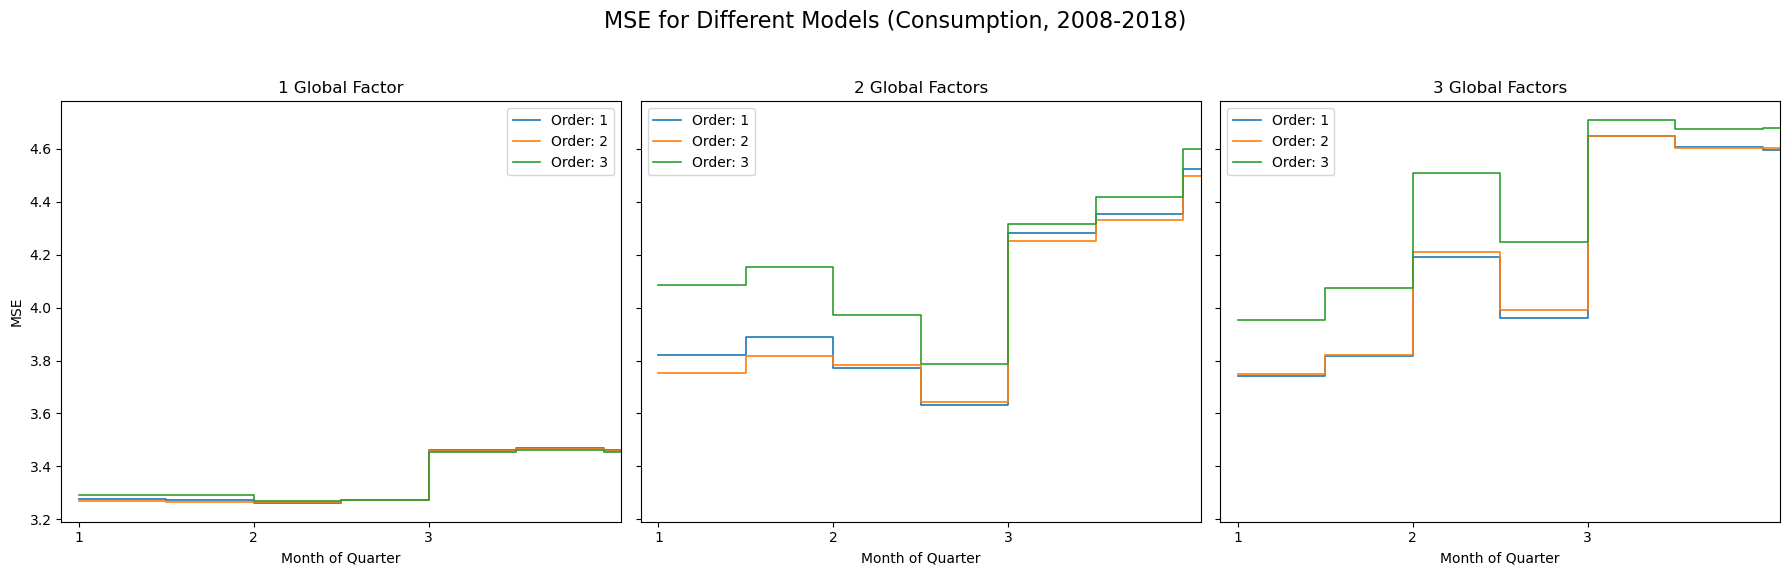

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd

vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]
q_var = 'Consumption'  

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Define the directory containing MSE files
mse_dir = f"../MSE/DFM_hard_surveys_global_factors_{q_var}"

# Create a figure with 1 row and 3 columns of subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Loop over each number of global factors (1, 2, and 3)
for i, num_factors in enumerate(range(1, 4)):
    ax = axs[i]
    # Within each subplot, loop over factor orders 1 to 3
    for order in range(1, 4):
        # Construct file name based on the model's parameters
        factors_str = f"Global_{num_factors}_{order}"
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_file_path = os.path.join(mse_dir, mse_file_name)
        
        # Load the MSE values from file
        mse_df = pd.read_csv(mse_file_path)
        # Construct y values based on the vintages
        y_values = [mse_df[col].iloc[0] for col in vintage_col_names]
        
        # Extend the y-values so the step function holds the last value
        y_extended = y_values.copy()
        y_extended.append(y_values[-1]) # Repeat the last value
        
        # Plot the step function for the current model
        ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                 label=f"Order: {order}")
        
    # Customize the subplot
    ax.set_xlabel("Month of Quarter")
    # Set ticks only at 1, 2, and 3 to mark the beginning of each month
    ax.set_xticks([1, 2, 3])
    ax.set_xlim(0.9, 4.1)
    ax.set_title(f"{num_factors} Global Factor{'s' if num_factors > 1 else ''}")
    if i == 0:  # Only the leftmost subplot gets the y-axis label
        ax.set_ylabel("MSE")
    ax.legend()

plt.suptitle(f"MSE for Different Models ({q_var}, 2008-2018)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
os.makedirs(f"../plots/DFM_hard_surveys_global_factors_{q_var}", exist_ok=True)
base_filename = os.path.join(f"../plots/DFM_hard_surveys_global_factors_{q_var}", f"DFM_hard_surveys_global_factors_2008-2018_{q_var}")
plt.savefig(f"{base_filename}.png", format="png")
plt.savefig(f"{base_filename}.eps", format="eps")

plt.show()

Plot MSE values for all models evaluated over the 2008–2010 and 2011-2018 periods.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


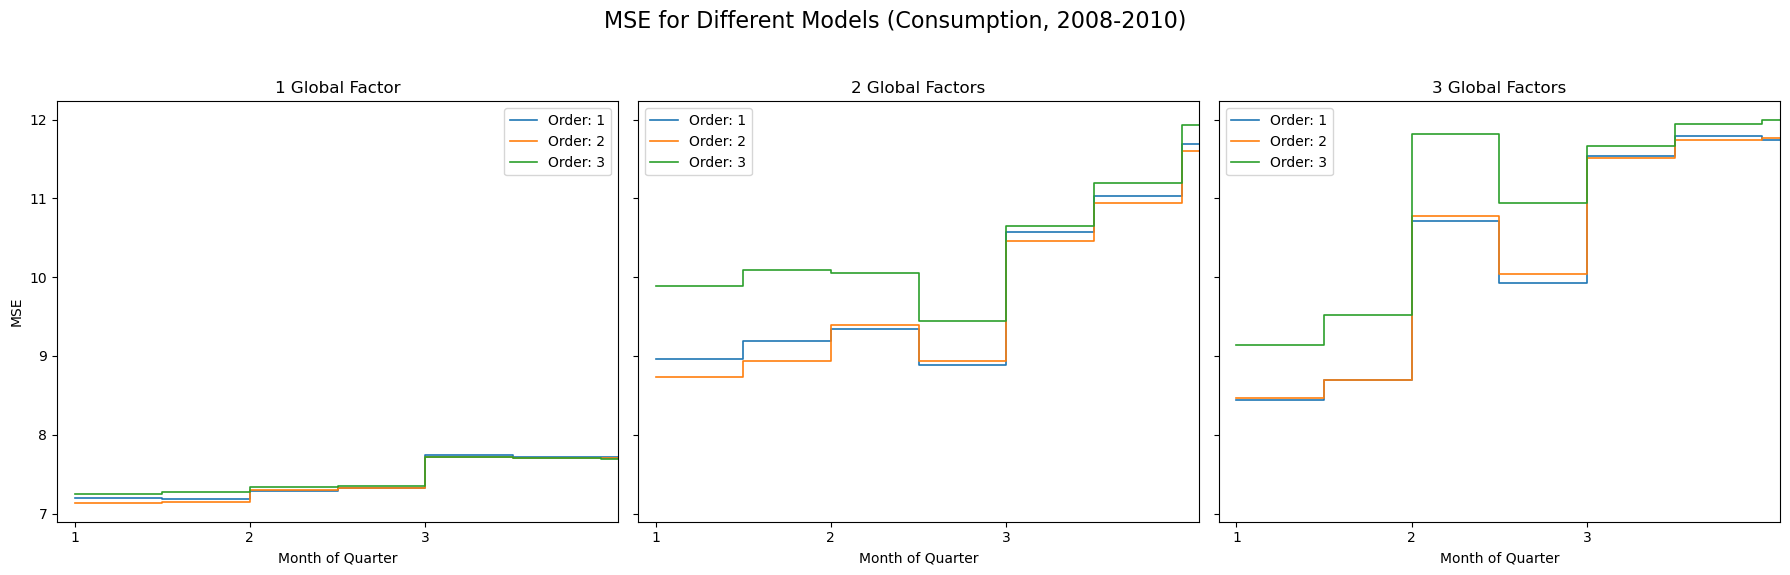

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


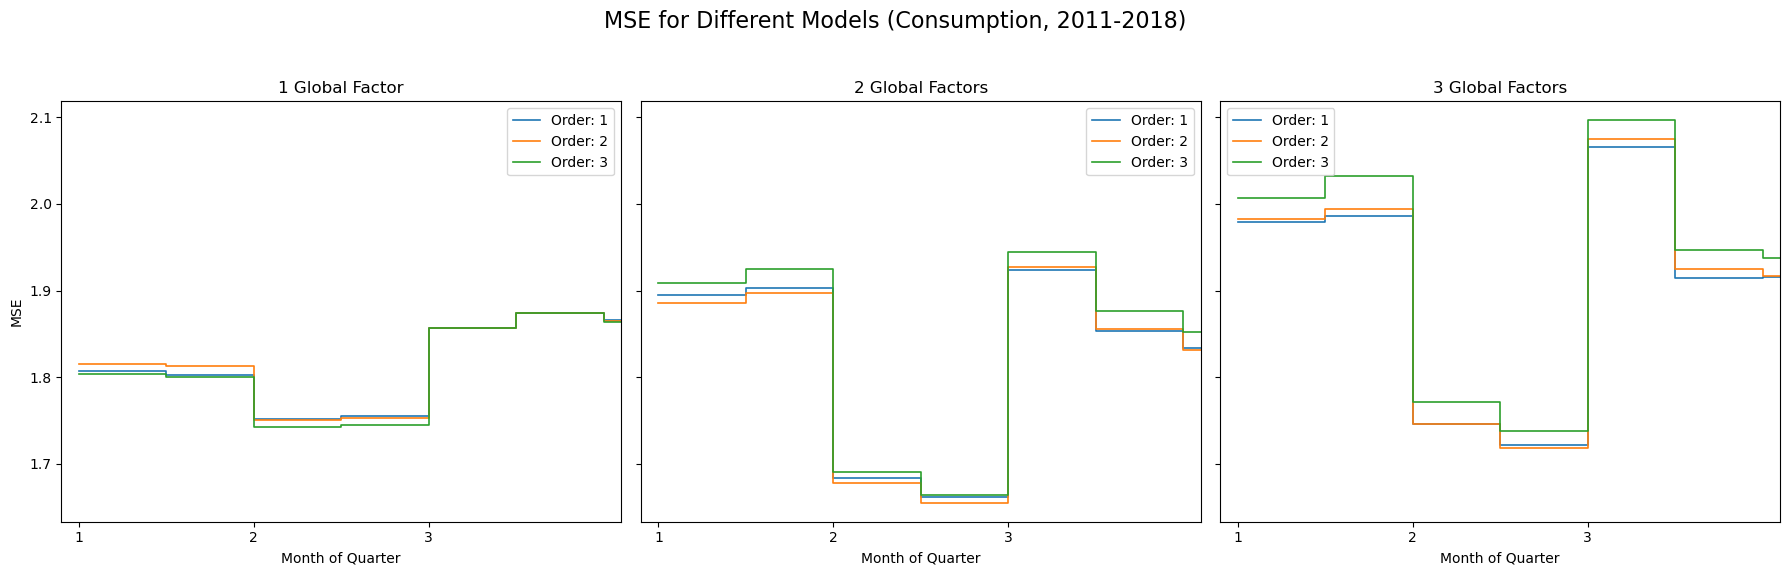

In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Consumption'
forecasts_dir = f"../forecasts/DFM_hard_surveys_global_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Define two periods
periods = {
    "2008-2010": lambda df: df["date_float"] < 2011,
    "2011-2018": lambda df: df["date_float"] >= 2011
}

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Loop over each period and create a separate figure
for period_label, period_filter in periods.items():
    
    # Create a figure with 1 row and 3 columns of subplots
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    
    # Loop over each number of global factors (1, 2, and 3)
    for i, num_factors in enumerate(range(1, 4)):
        ax = axs[i]
        # Within each subplot, loop over factor orders 1 to 3
        for order in range(1, 4):
            # Construct forecast file name, e.g., "forecasts_Consumption_Global_1_1.csv"
            factors_str = f"Global_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)
    
            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)
            
            # Merge forecasts with actual growth 
            merged = pd.merge(forecasts, actual_growth, on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)
            
            # Filter merged data for the current period
            merged_period = merged[ period_filter(merged) ]
            
            # Calculate MSE for each vintage column over the filtered period
            mse_dict = {}
            for col in vintage_col_names:
                mse = ((merged_period[col] - merged_period["growth"]) ** 2).mean()
                mse_dict[col] = mse
                
            # Construct y values based on the vintages
            y_values = [mse_dict[col] for col in vintage_col_names]
            
            # Extend the y-values so the step function holds the last value
            y_extended = y_values.copy()
            y_extended.append(y_values[-1]) # Repeat the last value
            
            # Plot the step function for the current model (order)
            ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                    label=f"Order: {order}")
            
        # Customize the subplot
        ax.set_xlabel("Month of Quarter")
        # Set ticks only at 1, 2, and 3 to mark the beginning of each month
        ax.set_xticks([1, 2, 3])
        ax.set_xlim(0.9, 4.1)
        ax.set_title(f"{num_factors} Global Factor{'s' if num_factors > 1 else ''}")
        if i == 0:  # Only the leftmost subplot gets the y-axis label
            ax.set_ylabel("MSE")
        ax.legend()
   
    plt.suptitle(f"MSE for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_hard_surveys_global_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_hard_surveys_global_factors_{q_var}", f"DFM_hard_surveys_global_factors_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()

Plot forecasts vs actual growth values for all models and different time periods (2008-2010, 2008-2018, and 2011-2018).

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


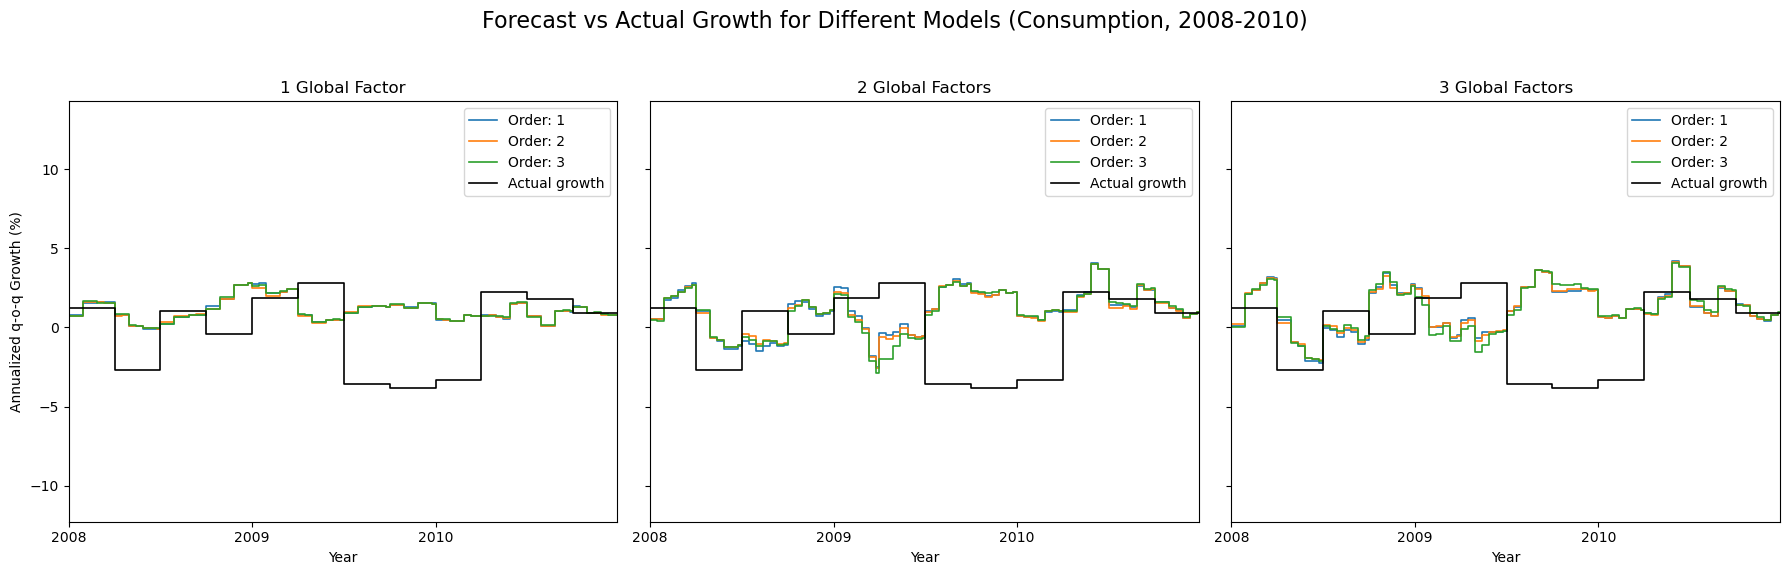

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


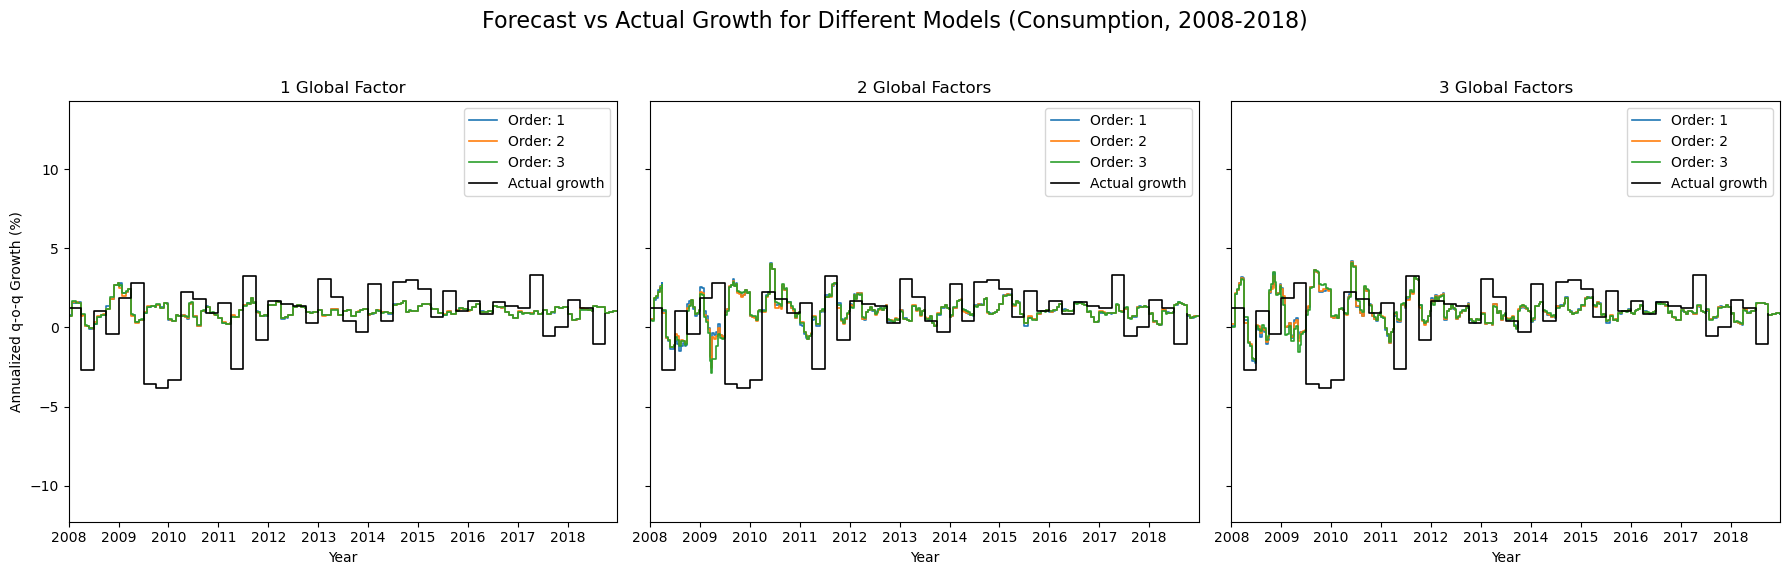

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


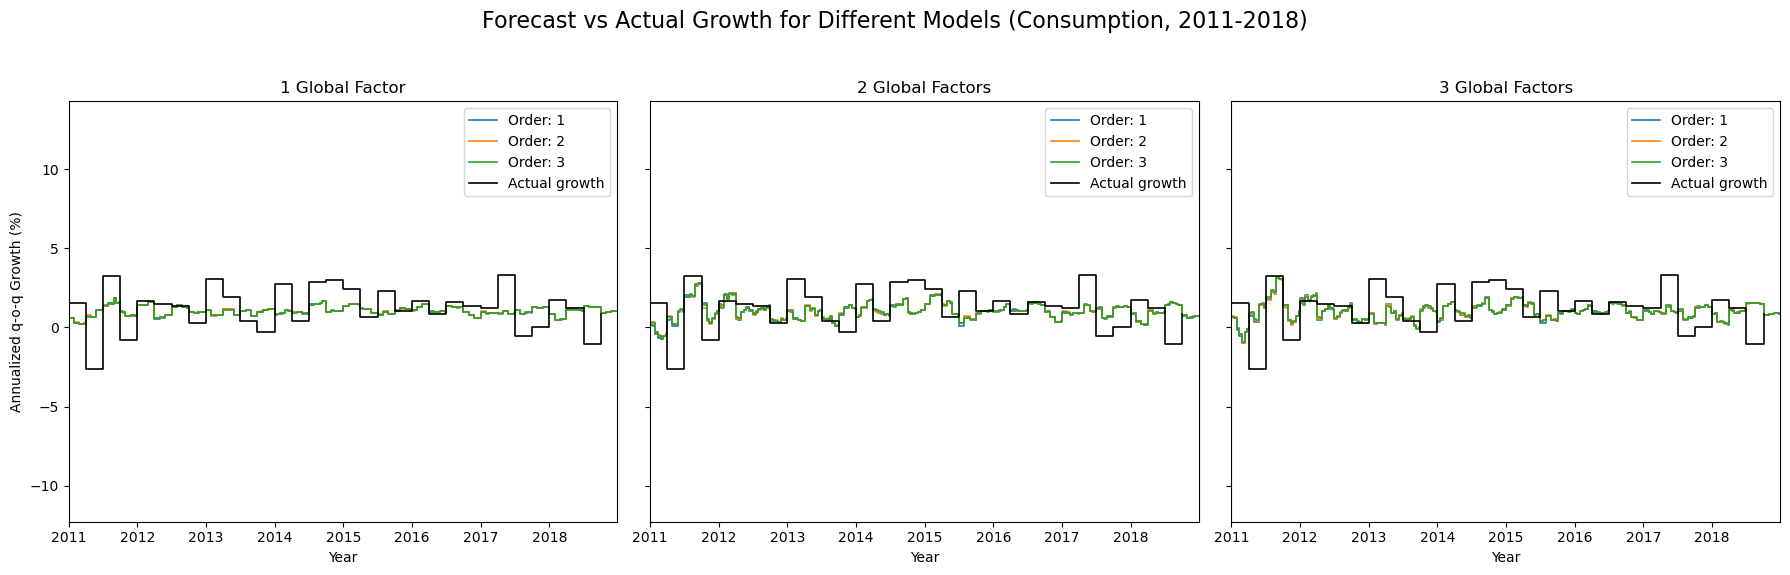

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert quarter strings like "2008-03" into a float (e.g. 2008.00 for Q1, 2008.25 for Q2, etc.)
def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Consumption'
forecasts_dir = f"../forecasts/DFM_hard_surveys_global_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Assign 7 small offsets within each quarter, so each quarter has 7 forecast points
offsets = np.linspace(0, 0.23, 7)

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Build x,y arrays for the actual growth
x_act = actual_growth["date_float"].tolist()
y_act = actual_growth["growth"].tolist()

# Define period configurations: x-axis limits and tick positions for each period
period_configs = {
    "2008-2010": {"xlim": (2008, 2010.99), "xticks": list(range(2008, 2011))},
    "2008-2018": {"xlim": (2008, 2018.99), "xticks": list(range(2008, 2019))},
    "2011-2018": {"xlim": (2011, 2018.99), "xticks": list(range(2011, 2019))}
}

# Loop over each period configuration to create and save separate plots
for period_label, config in period_configs.items():

    # Create a figure with 1 row and 3 columns for the three global factor counts
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

    # Loop over each global factor count (1, 2, and 3)
    for i, num_factors in enumerate([1, 2, 3]):
        ax = axs[i]

        # For each global factor count, plot forecasts for orders 1, 2, and 3
        for order in range(1, 4):

            # Construct forecast file name, e.g., "forecasts_Consumption_Global_1_1.csv"
            factors_str = f"Global_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)

            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)

            # Merge forecasts with actual growth dates
            merged = pd.merge(forecasts, actual_growth[['date']], on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)

            # Build forecast x and y arrays 
            x_fore = []
            y_fore = []
            for idx, row in merged.iterrows():
                base_x = row["date_float"]
                # For each of the 7 vintage columns, define an x-position and take that forecast value
                for j, col in enumerate(vintage_col_names):
                    x_fore.append(base_x + offsets[j])
                    y_fore.append(row[col])

            # Plot the forecast step curve for the current order
            ax.step(x_fore, y_fore, where='post', linewidth=1.2, label=f"Order: {order}")

        # Plot actual growth as a step plot in each subplot
        ax.step(x_act, y_act, where='post', color='black', linewidth=1.2, label="Actual growth")

        # Customize the subplot
        ax.set_xlabel("Year")
        ax.set_xlim(config["xlim"][0], config["xlim"][1])
        ax.set_xticks(config["xticks"])
        ax.set_title(f"{num_factors} Global Factor{'s' if num_factors > 1 else ''}")
        if i == 0:
            ax.set_ylabel("Annualized q-o-q Growth (%)")
        ax.legend()
        
    plt.suptitle(f"Forecast vs Actual Growth for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_hard_surveys_global_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_hard_surveys_global_factors_{q_var}", f"DFM_hard_surveys_global_factors_forecast_vs_actual_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()